In [8]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
#from cycler import cycler
import matplotlib.pyplot as plt
import scipy.stats as stats
#import statsmodels.formula.api as smf
import ipywidgets as widgets
# from matplotlib.patches import Polygon
# from matplotlib.gridspec import GridSpec

from myst_nb import glue # for the Jupyter book chapter

# Comparing one or two means

```{note}
This chapter is adapted from Danielle Navarro's excellent [Learning Statistics with R](https://learningstatisticswithr.com) book.  The main text has mainly be left intact with a few modifications, also the code adapted to use python and jupyter.
```

In many cases in science you will find yourself in a situation where your outcome variable is interval scale or higher, and what you're interested in is whether the average value of the outcome variable is higher in one group or another. For instance, a psychologist might want to know if anxiety levels are higher among parents than non-parents, or if working memory capacity is reduced by listening to music (relative to not listening to music). In a medical context, we might want to know if a new drug increases or decreases blood pressure. An agricultural scientist might want to know whether adding phosphorus to Australian native plants will kill them. In all these situations, our outcome variable is a fairly continuous, interval or ratio scale variable; and our predictor is a binary "grouping" variable. In other words, we want to compare the means of the two groups. 

Informal experimentation in my garden suggests that yes, it does. Australian natives are adapted to low phosphorus levels relative to everywhere else on Earth, apparently, so if you've bought a house with a bunch of exotics and you want to plant natives, don't follow my example: keep them separate. Nutrients to European plants are poison to Australian ones. There's probably a joke in that, but I can't figure out what it is.

The standard answer to the problem of comparing means is to use a $t$-test, of which there are several varieties depending on exactly what question you want to solve. As a consequence, the majority of this chapter focuses on different types of $t$-test: one sample $t$-tests, independent samples $t$-tests and Welcht test, and paired samples $t$-tests. After that, we'll talk a bit about Cohen's $d$, which is the standard measure of effect size for a $t$-test. The later sections of the chapter focus on the assumptions of the $t$-tests, and possible remedies if they are violated. However, before discussing any of these useful things, we'll start with a discussion of the $z$-test. 

## The one-sample $z$-test

In this section I'll describe one of the most useless tests in all of statistics: the **_$z$-test_**. Seriously -- this test is almost never used in real life. Its only real purpose is that, when teaching statistics, it's a very convenient stepping stone along the way towards the $t$-test, which is probably the most (over)used tool in all statistics.

### The inference problem that the test addresses

To introduce the idea behind the $z$-test, let's use a simple example. A friend of mine, Dr Zeppo, grades his introductory statistics class on a curve. Let's suppose that the average grade in his class is 67.5, and the standard deviation is 9.5. Of his many hundreds of students, it turns out that 20 of them also take psychology classes. Out of curiosity, I find myself wondering: do the psychology students tend to get the same grades as everyone else (i.e., mean 67.5) or do they tend to score higher or lower? He emails me the `zeppo.csv` file, which I use to pull up the `grades` of those students, 

In [25]:
zeppo_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/zeppo.csv',index_col=0)
zeppo_df.columns=["grades"]
zeppo_df.grades

1     50
2     60
3     60
4     64
5     66
6     66
7     67
8     69
9     70
10    74
11    76
12    76
13    77
14    79
15    79
16    79
17    81
18    82
19    82
20    89
Name: grades, dtype: int64

and calculate the mean:

In [14]:
zeppo_df.grades.mean()

72.3

Hm. It *might* be that the psychology students are scoring a bit higher than normal: that sample mean of $\bar{X} = 72.3$ is a fair bit higher than the hypothesised population mean of $\mu = 67.5$, but on the other hand, a sample size of $N = 20$ isn't all that big. Maybe it's pure chance. 

To answer the question, it helps to be able to write down what it is that I think I know. Firstly, I know that the sample mean is $\bar{X} = 72.3$. If I'm willing to assume that the psychology students have the same standard deviation as the rest of the class then I can say that the population standard deviation is $\sigma = 9.5$. I'll also assume that since Dr Zeppo is grading to a curve, the psychology student grades are normally distributed. 

Next, it helps to be clear about what I want to learn from the data. In this case, my research hypothesis relates to the *population* mean $\mu$ for the psychology student grades, which is unknown. Specifically, I want to know if $\mu = 67.5$ or not. Given that this is what I know, can we devise a hypothesis test to solve our problem? The data, along with the hypothesised distribution from which they are thought to arise, are shown in {numref}`fig:zeppo`. Not entirely obvious what the right answer is, is it? For this, we are going to need some statistics.

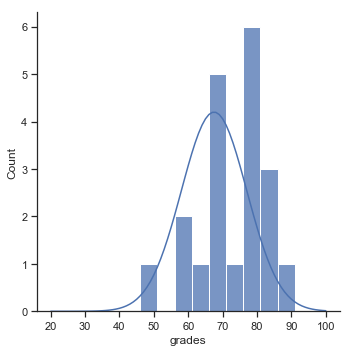

In [4]:
sns_fig=sns.displot(zeppo_df.grades,bins=np.arange(31,101,5),kde=False)

x=np.arange(20,101)
y=stats.norm.pdf(x,67.5,9.5)
plt.plot(x,y*100)  # just for display purposes scaling the size of the normal distribution
#plt.show()

glue("zeppo_fig",sns_fig.fig,display=False)

```{glue:figure} zeppo_fig
:figwidth: 550px
:name: "fig:zeppo"

The theoretical distribution (solid line) from which the psychology student grades (grey bars) are supposed to have been generated.
```

### Constructing the hypothesis test

The first step in constructing a hypothesis test is to be clear about what the null and alternative hypotheses are. This isn't too hard to do. Our null hypothesis, $H_0$, is that the true population mean $\mu$ for psychology student grades is 67.5\%; and our alternative hypothesis is that the population mean *isn't* 67.5\%. If we write this in mathematical notation, these hypotheses become,

$
\begin{array}{ll}
H_0: & \mu = 67.5 \\
H_1: & \mu \neq 67.5
\end{array}
$

though to be honest this notation doesn't add much to our understanding of the problem, it's just a compact way of writing down what we're trying to learn from the data. The null hypotheses $H_0$ and the alternative hypothesis $H_1$ for our test are both illustrated in Figure 2. In addition to providing us with these hypotheses, the scenario outlined above provides us with a fair amount of background knowledge that might be useful. Specifically, there are two special pieces of information that we can add:

1. The psychology grades are normally distributed.
1. The true standard deviation of these scores $\sigma$ is known to be 9.5.

For the moment, we'll act as if these are absolutely trustworthy facts. In real life, this kind of absolutely trustworthy background knowledge doesn't exist, and so if we want to rely on these facts we'll just have make the *assumption* that these things are true. However, since these assumptions may or may not be warranted, we might need to check them. For now though, we'll keep things simple.

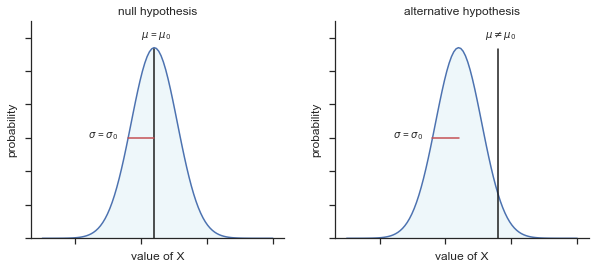

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


x = np.linspace(-5,30,100)
x2 = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 12,3.5)
y2=stats.norm.pdf(x2,15,3.5)

ax[0].plot(x,y)
ax[0].set_ylabel("probability")
ax[0].set_xlabel("value of X")
ax[0].set_title("null hypothesis")
ax[0].set_ylim(0,0.13)
ax[0].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[0].plot([12,12],[0,0.113],color='k')
ax[0].plot([8,12],[0.06,0.06],color='r')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].annotate("$\sigma$ = $\sigma_0$", xy=(2,0.06),xytext=(2,0.06))
ax[0].annotate("$\mu$ = $\mu_0$", xy=(10,0.12),xytext=(10,0.12))





ax[1].plot(x,y)
ax[1].set_ylabel("probability")
ax[1].set_xlabel("value of X")
ax[1].set_title("alternative hypothesis")
ax[1].set_ylim(0,0.13)
ax[1].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[1].plot([8,12],[0.06,0.06],color='r')
ax[1].plot([18,18],[0,0.113],color='k')
ax[1].annotate("$\sigma$ = $\sigma_0$", xy=(2,0.06),xytext=(2,0.06))
ax[1].annotate("$\mu \\neq \mu_0$", xy=(16,0.12),xytext=(16,0.12))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

sns.despine(top=True, right=True)

#plt.show()
glue("ztest_hypo_fig",fig,display=False)

```{glue:figure} ztest_hypo_fig
:figwidth: 650px
:name: "fig:ztest_hypo"

Graphical illustration of the null and alternative hypotheses assumed by the one sample $z$-test (the two sided version, that is). The null and alternative hypotheses both assume that the population distribution is normal, and additionally assumes that the population standard deviation is known (fixed at some value $\\sigma_0$). The null hypothesis (left) is that the population mean $\mu$ is equal to some specified value $\mu_0$. The alternative hypothesis is that the population mean differs from this value, $\mu \neq \mu_0$.
```

The next step is to figure out what we would be a good choice for a diagnostic test statistic; something that would help us discriminate between $H_0$ and $H_1$. Given that the hypotheses all refer to the population mean $\mu$, you'd feel pretty confident that the sample mean $\bar{X}$ would be a pretty useful place to start. What we could do, is look at the difference between the sample mean $\bar{X}$ and the value that the null hypothesis predicts for the population mean. In our example, that would mean we calculate $\bar{X} - 67.5$. More generally, if we let $\mu_0$ refer to the value that the null hypothesis claims is our population mean, then we'd want to calculate
$
\bar{X} - \mu_0
$
If this quantity equals or is very close to 0, things are looking good for the null hypothesis. If this quantity is a long way away from 0, then it's looking less likely that the null hypothesis is worth retaining. But how far away from zero should it be for us to reject $H_0$? 

To figure that out, we need to be a bit more sneaky, and we'll need to rely on those two pieces of background knowledge that I wrote down previously, namely that the raw data are normally distributed, and we know the value of the population standard deviation $\sigma$. If the null hypothesis is actually true, and the true mean is $\mu_0$, then these facts together mean that we know the complete population distribution of the data: a normal distribution with mean $\mu_0$ and standard deviation $\sigma$. A statistician might write this as:

$
X \sim \mbox{Normal}(\mu_0,\sigma^2)
$

Okay, if that's true, then what can we say about the distribution of $\bar{X}$? Well, as we discussed earlier, the sampling distribution of the mean $\bar{X}$ is also normal, and has mean $\mu$. But the standard deviation of this sampling distribution $\mbox{SE}({\bar{X}})$, which is called the *standard error of the mean*, is
$
\mbox{SE}({\bar{X}}) = \frac{\sigma}{\sqrt{N}}
$
In other words, if the null hypothesis is true then the sampling distribution of the mean can be written as follows:
$
\bar{X} \sim \mbox{Normal}(\mu_0,\mbox{SE}({\bar{X}}))
$
Now comes the trick. What we can do is convert the sample mean $\bar{X}$ into a standard score. This is conventionally written as $z$, but for now I'm going to refer to it as $z_{\bar{X}}$. (The reason for using this expanded notation is to help you remember that we're calculating standardised version of a sample mean, *not* a standardised version of a single observation, which is what a $z$-score usually refers to). When we do so, the $z$-score for our sample mean is 
$
z_{\bar{X}} = \frac{\bar{X} - \mu_0}{\mbox{SE}({\bar{X}})}
$
or, equivalently
$
z_{\bar{X}} =  \frac{\bar{X} - \mu_0}{\sigma / \sqrt{N}}
$
This $z$-score is our test statistic. The nice thing about using this as our test statistic is that like all $z$-scores, it has a standard normal distribution:
$
z_{\bar{X}} \sim \mbox{Normal}(0,1)
$
In other words, regardless of what scale the original data are on, the $z$-statistic iteself always has the same interpretation: it's equal to the number of standard errors that separate the observed sample mean $\bar{X}$ from the population mean $\mu_0$ predicted by the null hypothesis. Better yet, regardless of what the population parameters for the raw scores actually are, the 5\% critical regions for $z$-test are always the same, as illustrated in {numref}`fig:ztest_twoside_fig` and {numref}`fig:ztest_twoside_fig`. And what this meant, way back in the days where people did all their statistics by hand, is that someone could publish a table like this:

In [28]:
pd.DataFrame({"desired alpha level": [.1, 0.05, 0.01, 0.001], "two-sided test": [1.644854,1.959964,2.575829,3.290527],"one-sided test":[1.281552,1.644854,2.326348,3.090232]})

,desired alpha level,two-sided test,one-sided test
0,0.100,1.644854,1.281552
1,0.050,1.959964,1.644854
2,0.010,2.575829,2.326348
3,0.001,3.290527,3.090232


which in turn meant that researchers could calculate their $z$-statistic by hand, and then look up the critical value in a text book.  That was an incredibly handy thing to be able to do back then, but it's kind of unnecessary these days, since it's trivially easy to do it with software like R.

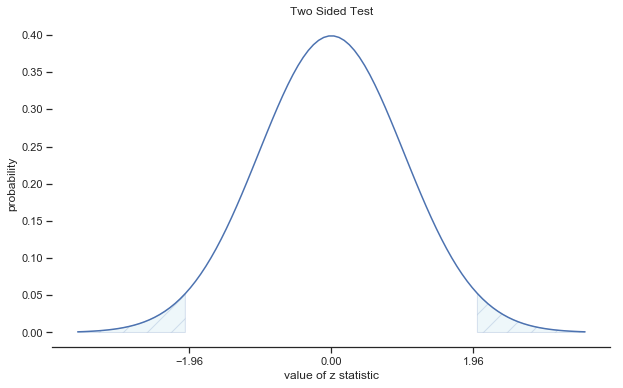

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x=np.linspace(-3.5,3.5,100)
y=stats.norm.pdf(x,0,1.0)

ax.plot(x,y)
ax.set_ylabel("probability")
ax.set_xlabel("value of z statistic")
ax.set_title("Two Sided Test")
#ax.set_ylim(0,0.5)
#ax.set_xlim(-3,3)
ax.fill_between(x,y,where=x<-1.96,interpolate=True,facecolor='lightblue',alpha=0.2,hatch='/',edgecolor='b')
ax.fill_between(x,y,where=x>1.96,interpolate=True,facecolor='lightblue',alpha=0.2,hatch='/',edgecolor='b')
ax.set_xticks([-1.96, 0, 1.96])
#ax.set_yticklabels([])


sns.despine(top=True, right=True, left=True)

#plt.show()
glue("ztest_twoside_fig",fig,display=False)

```{glue:figure} ztest_twoside_fig
:figwidth: 650px
:name: "fig:ztest_twoside_hypo"

Rejection regions for the two-sided $z$-test
```

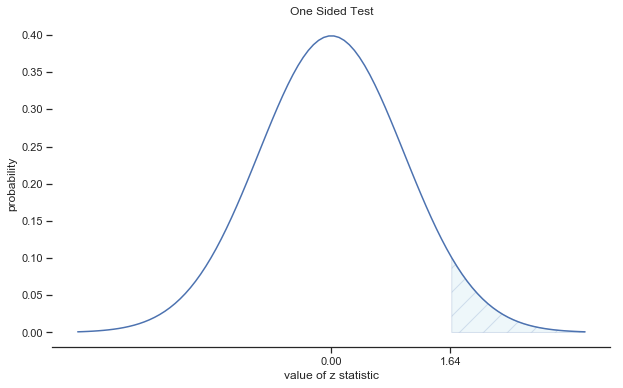

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,6))


x=np.linspace(-3.5,3.5,100)
y=stats.norm.pdf(x,0,1.0)

ax.plot(x,y)
ax.set_ylabel("probability")
ax.set_xlabel("value of z statistic")
ax.set_title("One Sided Test")
ax.fill_between(x,y,where=x>1.64,interpolate=True,facecolor='lightblue',alpha=0.2,hatch='/',edgecolor='b')
ax.set_xticks([0, 1.64])
#ax.set_yticklabels([])


sns.despine(top=True, right=True, left=True)

#plt.show()
glue("ztest_oneside_fig",fig,display=False)

```{glue:figure} ztest_oneside_fig
:figwidth: 650px
:name: "fig:ztest_oneside_hypo"

Rejection regions for the one-sided $z$-test
```

### A worked example using Python

Now, as I mentioned earlier, the $z$-test is almost never used in practice.  There is a function called [ztest](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html) in statsmodels.  However, the test is so incredibly simple that it's really easy to do one manually. Let's go back to the data from Dr Zeppo's class. Having loaded the `grades` data, the first thing I need to do is calculate the sample mean:

In [35]:
zeppo_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/zeppo.csv',index_col=0)
zeppo_df.columns=["grades"]
sample_mean = zeppo_df.grades.mean()
print(sample_mean)

72.3


Then, I create variables corresponding to known population standard deviation ($\sigma = 9.5$), and the value of the population mean that the null hypothesis specifies ($\mu_0 = 67.5$):

In [36]:
mu_null = 67.5
sd_true = 9.5 

Let's also create a variable for the sample size. We could count up the number of observations ourselves, and type `N <- 20` at the command prompt, but counting is tedious and repetitive. Let's get R to do the tedious repetitive bit by using the `length()` function, which tells us how many elements there are in a vector:

In [37]:
N = len( zeppo_df.grades )
print( N )

20


Next, let's calculate the (true) standard error of the mean:

In [38]:
sem_true = sd_true / np.sqrt(N)
print(sem_true)

2.1242645786248002


And finally, we calculate our $z$-score:

In [39]:
z_score = (sample_mean - mu_null) / sem_true
print( z_score )

2.259605535157681


At this point, we would traditionally look up the value 2.26 in our table of critical values. Our original hypothesis was two-sided (we didn't really have any theory about whether psych students would be better or worse at statistics than other students) so our hypothesis test is two-sided (or two-tailed) also. Looking at the little table that I showed earlier, we can see that 2.26 is bigger than the critical value of 1.96 that would be required to be significant at $\alpha = .05$, but smaller than the value of 2.58 that would be required to be significant at a level of $\alpha = .01$. Therefore, we can conclude that we have a significant effect, which we might write up by saying something like this:

> With a mean grade of 73.2 in the sample of psychology students, and assuming a true population standard deviation of 9.5, we can conclude that the psychology students have significantly different statistics scores to the class average ($z = 2.26$, $N=20$, $p<.05$).
                                                                                                                                     
However, what if want an exact $p$-value? Well, back in the day, the tables of critical values were huge, and so you could look up your actual $z$-value, and find the smallest value of $\alpha$ for which your data would be significant (which, as discussed earlier, is the very definition of a $p$-value). However, looking things up in books is tedious, and typing things into computers is awesome. So let's do it using python instead. Now, notice that the $\alpha$ level of a $z$-test (or any other test, for that matter) defines the total area "under the curve" for the critical region, right? That is, if we set $\alpha = .05$ for a two-sided test, then the critical region is set up such that the area under the curve for the critical region is $.05$. And, for the $z$-test, the critical value of 1.96 is chosen that way because the area in the lower tail (i.e., below $-1.96$) is exactly $.025$ and the area under the upper tail (i.e., above $1.96$) is exactly $.025$. So, since our observed $z$-statistic is $2.26$, why not calculate the area under the curve below $-2.26$ or above $2.26$? In R we can calculate this using the `stats.norm.cdf()` function (stands for cumulative density function). For the upper tail:

In [40]:
upper_area = 1.0-stats.norm.cdf(z_score)
print(upper_area)

0.011922871882469877


Notice that I subtract this cdf from 1.0.  This allows me to compute area under the curve from 2.26 *and upwards*. To get the area in the lower tail I just compute the CDF up to the negative of the zscore (the value it would take on the other side of the distribution. There is no need to subtract from 1.0 this time because the CDF calculates from the left up to the z-score you give it.

In [41]:
lower_area = stats.norm.cdf(-z_score)
print(lower_area)

0.011922871882469896


Thus we get our $p$-value:

In [42]:
p_value = lower_area + upper_area
print( p_value )

0.023845743764939774


### Assumptions of the $z$-test

As I've said before, all statistical tests make assumptions. Some tests make reasonable assumptions, while other tests do not. The test I've just described -- the one sample $z$-test -- makes three basic assumptions.  These are:

- *Normality*. As usually described, the $z$-test assumes that the true population distribution is normal.[^normality] is often pretty reasonable, and not only that, it's an assumption that we can check if we feel worried about it (see below). 
- *Independence*. The second assumption of the test is that the observations in your data set are not correlated with each other, or related to each other in some funny way. This isn't as easy to check statistically: it relies a bit on good experimental design. An obvious (and stupid) example of something that violates this assumption is a data set where you "copy" the same observation over and over again in your data file: so you end up with a massive "sample size", consisting of only one genuine observation. More realistically, you have to ask yourself if it's really plausible to imagine that each observation is a completely random sample from the population that you're interested in. In practice, this assumption is never met; but we try our best to design studies that minimize the problems of correlated data. 
- *Known standard deviation*. The third assumption of the $z$-test is that the true standard deviation of the population is known to the researcher. This is just stupid. In no real world data analysis problem do you know the standard deviation $\sigma$ of some population, but are completely ignorant about the mean $\mu$. In other words, this assumption is *always* wrong. 

In view of the stupidity of assuming that $\sigma$ is known, let's see if we can live without it. This takes us out of the dreary domain of the $z$-test, and into the magical kingdom of the $t$-test, with unicorns and fairies and leprechauns, and um...

[^normality]: Actually this is too strong. Strictly speaking the $z$ test only requires that the sampling distribution of the mean be normally distributed; if the population is normal then it necessarily follows that the sampling distribution of the mean is also normal. However, as we saw when talking about the central limit theorem, it's quite possible (even commonplace) for the sampling distribution to be normal even if the population distribution itself is non-normal. However, in light of the sheer ridiculousness of the assumption that the true standard deviation is known, there really isn't much point in going into details on this front!

## The one-sample $t$-test

After some thought, I decided that it might not be safe to assume that the psychology student grades necessarily have the same standard deviation as the other students in Dr Zeppo's class. After all, if I'm entertaining the hypothesis that they don't have the same mean, then why should I believe that they absolutely have the same standard deviation? In view of this, I should really stop assuming that I know the true value of $\sigma$. This violates the assumptions of my $z$-test, so in one sense I'm back to square one. However, it's not like I'm completely bereft of options. After all, I've still got my raw data, and those raw data give me an *estimate* of the population standard deviation:

In [52]:
zeppo_df['grades'].std(ddof=1)

9.520614752375915

In other words, while I can't say that I know that $\sigma = 9.5$, I *can* say that $\hat\sigma = 9.52$. 

Okay, cool. The obvious thing that you might think to do is run a $z$-test, but using the estimated standard deviation of 9.52 instead of relying on my assumption that the true standard deviation is 9.5. So, we could just type this new number into python and out would come the answer. And you probably wouldn't be surprised to hear that this would still give us a significant result. This approach is close, but it's not *quite* correct. Because we are now relying on an *estimate* of the population standard deviation, we need to make some adjustment for the fact that we have some uncertainty about what the true population standard deviation actually is. Maybe our data are just a fluke ... maybe the true population standard deviation is 11, for instance. But if that were actually true, and we ran the $z$-test assuming $\sigma=11$, then the result would end up being *non-significant*. That's a problem, and it's one we're going to have to address.

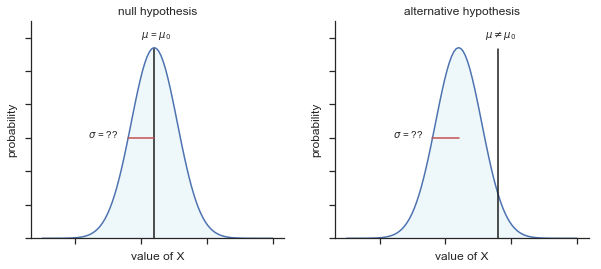

In [94]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


x = np.linspace(-5,30,100)
x2 = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 12,3.5)
y2=stats.norm.pdf(x2,15,3.5)

ax[0].plot(x,y)
ax[0].set_ylabel("probability")
ax[0].set_xlabel("value of X")
ax[0].set_title("null hypothesis")
ax[0].set_ylim(0,0.13)
ax[0].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[0].plot([12,12],[0,0.113],color='k')
ax[0].plot([8,12],[0.06,0.06],color='r')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].annotate("$\sigma$ = ??", xy=(2,0.06),xytext=(2,0.06))
ax[0].annotate("$\mu$ = $\mu_0$", xy=(10,0.12),xytext=(10,0.12))





ax[1].plot(x,y)
ax[1].set_ylabel("probability")
ax[1].set_xlabel("value of X")
ax[1].set_title("alternative hypothesis")
ax[1].set_ylim(0,0.13)
ax[1].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[1].plot([8,12],[0.06,0.06],color='r')
ax[1].plot([18,18],[0,0.113],color='k')
ax[1].annotate("$\sigma$ = ??", xy=(2,0.06),xytext=(2,0.06))
ax[1].annotate("$\mu \\neq \mu_0$", xy=(16,0.12),xytext=(16,0.12))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

sns.despine(top=True, right=True)

#plt.show()
glue("ttest_hypo_fig",fig,display=False)

```{glue:figure} ttest_hypo_fig
:figwidth: 650px
:name: "fig:ttest_hypo"

Graphical illustration of the null and alternative hypotheses assumed by the (two sided) one sample $t$-test. Note the similarity to the $z$-test. The null hypothesis is that the population mean $\mu$ is equal to some specified value $\mu_0$, and the alternative hypothesis is that it is not. Like the $z$-test, we assume that the data are normally distributed; but we do not assume that the population standard deviation $\sigma$ is known in advance.
```

### Introducing the $t$-test

This ambiguity is annoying, and it was resolved in 1908 by a guy called William Sealy Gosset {cite}`Student1908`, who was working as a chemist for the Guinness brewery at the time (see {cite}`Box1987`). [^gosset] Because Guinness took a dim view of its employees publishing statistical analysis (apparently they felt it was a trade secret), he published the work under the pseudonym "A Student", and to this day, the full name of the $t$-test is actually **_Student's $t$-test_**. The key thing that Gosset figured out is how we should accommodate the fact that we aren't completely sure what the true standard deviation is. The answer is that it subtly changes the sampling distribution. In the $t$-test, our test statistic (now called a $t$-statistic) is calculated in exactly the same way I mentioned above. If our null hypothesis is that the true mean is $\mu$, but our sample has mean $\bar{X}$ and our estimate of the population standard deviation is $\hat{\sigma}$, then our $t$ statistic is:
$
t = \frac{\bar{X} - \mu}{\hat{\sigma}/\sqrt{N} }
$
The only thing that has changed in the equation is that instead of using the known true value $\sigma$, we use the estimate $\hat{\sigma}$. And if this estimate has been constructed from $N$ observations, then the sampling distribution turns into a $t$-distribution with $N-1$ **_degrees of freedom_** (df). The $t$ distribution is very similar to the normal distribution, but has "heavier" tails as illustrated in Figure \@ref(fig:ttestdist). Notice, though, that as df gets larger, the $t$-distribution starts to look identical to the standard normal distribution. This is as it should be: if you have a sample size of $N = 70,000,000$ then your "estimate" of the standard deviation would be pretty much perfect, right? So, you should expect that for large $N$, the $t$-test would behave exactly the same way as a $z$-test. And that's exactly what happens!  


[^gosset]: Well, sort of. As I understand the history, Gosset only provided a partial solution: the general solution to the problem was provided by Sir Ronald Fisher.

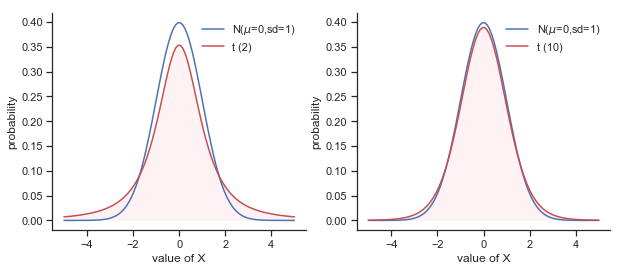

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


x = np.linspace(-5,5,100)
y= stats.norm.pdf(x, 0,1)
y2= stats.t.pdf(x,df=2,loc=0,scale=1)

ax[0].plot(x,y,label='N($\mu$=0,sd=1)')
ax[0].plot(x,y2,'r',label='t (2)')
ax[0].set_ylabel("probability")
ax[0].set_xlabel("value of X")
#ax[0].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[0].fill_between(x,y2, where=y>0.0,interpolate=True,facecolor='pink',alpha=0.2)
ax[0].legend(loc='best', frameon=False)
#ax[0].set_xticklabels([])
#ax[0].set_yticklabels([])


x = np.linspace(-5,5,100)
y=stats.norm.pdf(x,0,1)
y2=stats.t.pdf(x,10,0,1)

ax[1].plot(x,y,label='N($\mu$=0,sd=1)')
ax[1].plot(x,y2,'r',label='t (10)')
ax[1].set_ylabel("probability")
ax[1].set_xlabel("value of X")
#ax[1].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[1].fill_between(x,y2, where=y>0.0,interpolate=True,facecolor='pink',alpha=0.2)
ax[1].legend(loc='best', frameon=False)
sns.despine(top=True, right=True)

glue("ttestdist_fig",fig,display=False)

```{glue:figure} ttestdist_fig
:figwidth: 650px
:name: "fig:ttestdist"

The $t$ distribution with 2 degrees of freedom (left) and 10 degrees of freedom (right), with a standard normal distribution (i.e., mean 0 and std dev 1) plotted as a blue line for comparison purposes. Notice that the $t$ distribution has heavier tails (higher kurtosis) than the normal distribution; this effect is quite exaggerated when the degrees of freedom are very small, but negligible for larger values. In other words, for large $df$ the $t$ distribution is essentially identical to a normal distribution."))
```

### Doing the test in Python

As you might expect, the mechanics of the $t$-test are almost identical to the mechanics of the $z$-test. So there's not much point in going through the tedious exercise of showing you how to do the calculations using low level commands: it's pretty much identical to the calculations that we did earlier, except that we use the estimated standard deviation (i.e., something like `se_est = grades.std(ddof=1)`), and then we test our hypothesis using the $t$ distribution rather than the normal distribution  (i.e. we use `stats.t.cdf()` rather than `stats.norm.cdf()`. And so instead of going through the calculations in tedious detail for a second time, I'll jump straight to showing you how $t$-tests are actually done in practice. 

Python has a nice package called [pingouin](https://pingouin-stats.org/index.html) which provides easy access to most common statistics.  Although you can definitely find a t-test in [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ttest_ind.html) pingouin is really simple and fun.


To use this function we just import pinguoin:

In [5]:
import pingouin as pg

Next we run the function `pg.ttest`.  The documentation for this command is [here](https://pingouin-stats.org/generated/pingouin.ttest.html#pingouin.ttest). It's pretty straightforward to use: all you need to do is specify `x`, the variable containing the data, and `y`, the true population mean according to the null hypothesis. All you need to type is this:

In [6]:
pg.ttest(x=zeppo_df.grades,y=67.5)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.255,19,two-sided,0.036145,"[0.34, 9.26]",0.504,1.795,0.571


Easy enough. Now lets go through the output. 

The first column in the output it the value of the t-statistic (2.255).   The 'dof' refers to the degrees of freedom which is one less than the number of observations in x (so 19).  Here we conductes a two-sided test.  Then the $p$-value (0.036) of the test of the null hypothesis that the population mean equals 67.5 (what we provided as y). The confidence interval around the mean of the provided data $x$. The estimated effect size (cohen's d is 0.504), more on that later.  The final column is a Bayes Factor in support of the alternative hypothesis. Finally, the post-hoc power was estimated to be 0.571.  We will ignore that one for now.

So that seems straightforward enough. Now what do we *do* with this output? Well, since we're pretending that we actually care about my toy example, we're overjoyed to discover that the result is statistically significant (i.e. $p$ value below .05). We could report the result by saying something like this:

> With a mean grade of 72.3, the psychology students scored slightly higher than the average grade of 67.5 ($t(19) = 2.25$, $p<.05$).

where $t(19)$ is shorthand notation for a $t$-statistic that has 19 degrees of freedom. 

A technical comment... in the same way that we can weaken the assumptions of the $z$-test so that we're only talking about the sampling distribution, we *can* weaken the $t$ test assumptions so that we don't have to assume normality of the population. However, for the $t$-test, it's trickier to do this. As before, we can replace the assumption of population normality with an assumption that the sampling distribution of $\bar{X}$ is normal. However, remember that we're also relying on a sample estimate of the standard deviation; and so we also require the sampling distribution of $\hat{\sigma}$ to be chi-square. That makes things nastier, and this version is rarely used in practice: fortunately, if the population is normal, then both of these two assumptions are met, and as noted earlier, there are standard tools that you can use to check to see if this assumption is met (see below), and other tests you can do in it's place if this assumption is violated (also see below).

### Assumptions of the one sample $t$-test

Okay, so what assumptions does the one-sample $t$-test make? Well, since the $t$-test is basically a $z$-test with the assumption of known standard deviation removed, you shouldn't be surprised to see that it makes the same assumptions as the $z$-test, minus the one about the known standard deviation. That is

- *Normality*. We're still assuming that the the population distribution is normal.
- *Independence*. Once again, we have to assume that the observations in our sample are generated independently of one another. See the earlier discussion about the $z$-test for specifics.

Overall, these two assumptions aren't terribly unreasonable, and as a consequence the one-sample $t$-test is pretty widely used in practice as a way of comparing a sample mean against a hypothesised population mean.



## The independent samples $t$-test (Student test)

Although the one sample $t$-test has its uses, it's not the most typical example of a $t$-test. A much more common situation arises when you've got two different groups of observations. In psychology, this tends to correspond to two different groups of participants, where each group corresponds to a different condition in your study. For each person in the study, you measure some outcome variable of interest, and the research question that you're asking is whether or not the two groups have the same population mean. This is the situation that the independent samples $t$-test is designed for. 

### The data

Suppose we have 33 students taking Dr Harpo's statistics lectures, and Dr Harpo doesn't grade to a curve. Actually, Dr Harpo's grading is a bit of a mystery, so we don't really know anything about what the average grade is for the class as a whole. There are two tutors for the class, Anastasia and Bernadette. There are $N_1 = 15$ students in Anastasia's tutorials, and $N_2 = 18$ in Bernadette's tutorials. The research question I'm interested in is whether Anastasia or Bernadette is a better tutor, or if it doesn't make much of a difference. Dr Harpo emails me the course grades, in the `harpo.csv` (hosted on the course website) file. As usual, I'll load the file and have a look at what variables it contains:

In [55]:
harpo_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/harpo.csv',index_col=0)
harpo_df.head()

,grade,tutor
1,65,Anastasia
2,72,Bernadette
3,66,Bernadette
4,74,Anastasia
5,73,Anastasia


As we can see, there's a single data frame with two variables, `grade` and `tutor`. The `grade` variable is a numeric vector, containing the grades for all $N = 33$ students taking Dr Harpo's class; the `tutor` variable is a factor that indicates who each student's tutor was. The first fiv observations in this data set are shown above.

We can calculate means and standard deviations, using the `mean()` and `sd()` functions. Rather than show the R output, here's a nice little summary table:

In [56]:
harpo_df.groupby('tutor').describe()

grade                                                    
           count       mean       std   min    25%   50%   75%   max
tutor                                                               
Anastasia   15.0  74.533333  8.998942  55.0  69.00  76.0  79.0  90.0
Bernadette  18.0  69.055556  5.774918  56.0  66.25  69.0  73.0  79.0

To give you a more detailed sense of what's going on here, I've plotted histograms showing the distribution of grades for both tutors ({numref}`fig:anastasia` and {numref}`fig:bernadette`). Inspection of these histograms suggests that the students in Anastasia's class may be getting slightly better grades on average, though they also seem a little more variable.

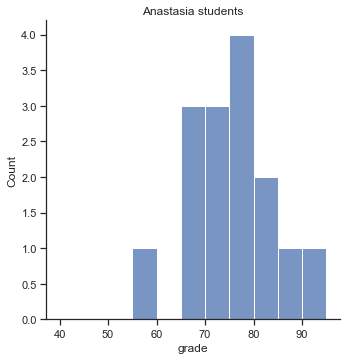

In [66]:
p1=sns.displot(harpo_df[harpo_df['tutor']=="Anastasia"].grade,bins=np.arange(40,100,5))
p1.ax.set_title("Anastasia students")
glue("anastasia_fig",p1.fig,display=False)

```{glue:figure} anastasia_fig
:figwidth: 550px
:name: "fig:anastasia"

Histogram showing the overall distribution of grades for students in Anastasia’s class.
```

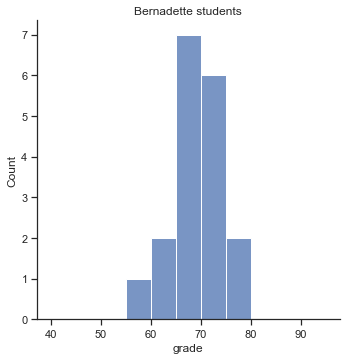

In [64]:
p2=sns.displot(harpo_df[harpo_df['tutor']=="Bernadette"].grade,bins=np.arange(40,100,5))
p2.ax.set_title("Bernadette students")
glue("bernadette_fig",p2.fig,display=False)

```{glue:figure} bernadette_fig
:figwidth: 550px
:name: "fig:bernadette"

Histogram showing the overall distribution of grades for students in Bernadette’s class.
```

Here is a simpler plot showing the means and corresponding confidence intervals for both groups of students ({numref}`fig:teachers`).

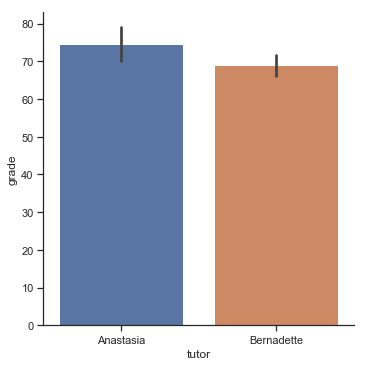

In [69]:
p1=sns.catplot(x="tutor", y="grade", data=harpo_df, kind='bar',ci=95)
glue("teachers_fig",p1.fig,display=False)

```{glue:figure} teachers_fig
:figwidth: 550px
:name: "fig:teachers"

Plot showing the mean grade for the students in Anastasia’s and Bernadette’s tutorials. Error bars depict 95% confidence intervals around the mean. On the basis of visual inspection, it does look like there’s a real difference between the groups, though it’s hard to say for sure.
```

### Introducing the test

The **_independent samples $t$-test_** comes in two different forms, Student's and Welch's. The original Student $t$-test -- which is the one I'll describe in this section -- is the simpler of the two, but relies on much more restrictive assumptions than the Welch $t$-test. Assuming for the moment that you want to run a two-sided test, the goal is to determine whether two "independent samples" of data are drawn from populations with the same mean (the null hypothesis) or different means (the alternative hypothesis). When we say "independent" samples, what we really mean here is that there's no special relationship between observations in the two samples. This probably doesn't make a lot of sense right now, but it will be clearer when we come to talk about the paired samples $t$-test later on. For now, let's just point out that if we have an experimental design where participants are randomly allocated to one of two groups, and we want to compare the two groups' mean performance on some outcome measure, then an independent samples $t$-test (rather than a paired samples $t$-test) is what we're after.

Okay, so let's let $\mu_1$ denote the true population mean for group 1 (e.g., Anastasia's students), and $\mu_2$ will be the true population mean for group 2 (e.g., Bernadette's students),[^funnyquestion] and as usual we'll let $\bar{X}_1$ and $\bar{X}_2$ denote the observed sample means for both of these groups. Our null hypothesis states that the two population means are identical ($\mu_1 = \mu_2$) and the alternative to this is that they are not ($\mu_1 \neq \mu_2$). Written in mathematical-ese, this is...

$
\begin{array}{ll}
H_0: & \mu_1 = \mu_2  \\
H_1: & \mu_1 \neq \mu_2
\end{array}
$

[^funnyquestion]: A funny question almost always pops up at this point: what the heck *is* the population being referred to in this case? Is it the set of students actually taking Dr Harpo's class (all 33 of them)? The set of people who might take the class (an unknown number) of them? Or something else? Does it matter which of these we pick? It's traditional in an introductory behavioral stats class to mumble a lot at this point, but since I get asked this question every year by my students, I'll give a brief answer. Technically yes, it does matter: if you change your definition of what the "real world" population actually is, then the sampling distribution of your observed mean $\bar{X}$ changes too. The $t$-test relies on an assumption that the observations are sampled at random from an infinitely large population; and to the extent that real life isn't like that, then the $t$-test can be wrong. In practice, however, this isn't usually a big deal: even though the assumption is almost always wrong, it doesn't lead to a lot of pathological behavior from the test, so we tend to just ignore it.

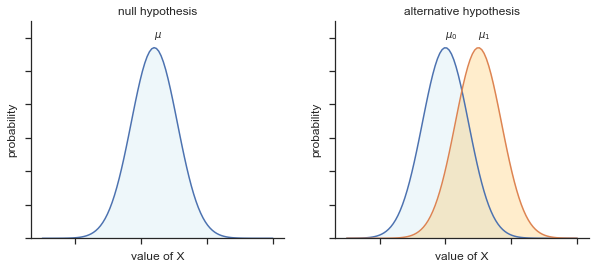

In [73]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


x = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 12,3.5)
y2=stats.norm.pdf(x,15,3.5)

ax[0].plot(x,y)
ax[0].set_ylabel("probability")
ax[0].set_xlabel("value of X")
ax[0].set_title("null hypothesis")
ax[0].set_ylim(0,0.13)
ax[0].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].annotate("$\mu$", xy=(12,0.12),xytext=(12,0.12))

x = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 10,3.5)
y2=stats.norm.pdf(x,15,3.5)


ax[1].plot(x,y)
ax[1].plot(x,y2)
ax[1].set_ylabel("probability")
ax[1].set_xlabel("value of X")
ax[1].set_title("alternative hypothesis")
ax[1].set_ylim(0,0.13)
ax[1].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[1].fill_between(x,y2, where=y>0.0,interpolate=True,facecolor='orange',alpha=0.2)
ax[1].annotate("$\mu_0$", xy=(10,0.12),xytext=(10,0.12))
ax[1].annotate("$\mu_1$", xy=(15,0.12),xytext=(15,0.12))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

sns.despine(top=True, right=True)
glue("twosamplettestdist_fig",fig,display=False)

```{glue:figure} twosamplettestdist_fig
:figwidth: 650px
:name: "fig:twosamplettestdist"

Graphical illustration of the null and alternative hypotheses assumed by the (two sided) one sample $t$-test. Note the similarity to the $z$-test. The null hypothesis is that the population mean $\\mu$ is equal to some specified value $\\mu_0$, and the alternative hypothesis is that it is not. Like the $z$-test, we assume that the data are normally distributed; but we do not assume that the population standard deviation $\\sigma$ is known in advance.
```

To construct a hypothesis test that handles this scenario, we start by noting that if the null hypothesis is true, then the difference between the population means is *exactly* zero, 

$\mu_1 - \mu_2 = 0$

As a consequence, a diagnostic test statistic will be based on the difference between the two sample means. Because if the null hypothesis is true, then we'd expect 

$
\bar{X}_1 - \bar{X}_2
$

to be *pretty close* to zero. However, just like we saw with our one-sample tests (i.e., the one-sample $z$-test and the one-sample $t$-test) we have to be precise about exactly *how close* to zero this difference should be. And the solution to the problem is more or less the same one: we calculate a standard error estimate (SE), just like last time, and then divide the difference between means by this estimate. So our **_$t$-statistic_** will be of the form

$
t = \frac{\bar{X}_1 - \bar{X}_2}{\mbox{SE}}
$

We just need to figure out what this standard error estimate actually is. This is a bit trickier than was the case for either of the two tests we've looked at so far, so we need to go through it a lot more carefully to understand how it works.



### A "pooled estimate" of the standard deviation

In the original "Student $t$-test", we make the assumption that the two groups have the same population standard deviation: that is, regardless of whether the population means are the same, we assume that the population standard deviations are identical, $\sigma_1 = \sigma_2$. Since we're assuming that the two standard deviations are the same, we drop the subscripts and refer to both of them as $\sigma$. How should we estimate this? How should we construct a single estimate of a standard deviation when we have two samples? The answer is, basically, we average them. Well, sort of. Actually, what we do is take a *weighed* average of the *variance* estimates, which we use as our **_pooled estimate of the variance_**. The weight assigned to each sample is equal to the number of observations in that sample, minus 1. Mathematically, we can write this as

$
\begin{array}{rcl}
w_1 &=& N_1 - 1\\
w_2 &=& N_2 - 1
\end{array}
$

Now that we've assigned weights to each sample, we calculate the pooled estimate of the variance by taking the weighted average of the two variance estimates, ${\hat\sigma_1}^2$ and ${\hat\sigma_2}^2$ 

$
\hat\sigma^2_p = \frac{w_1 {\hat\sigma_1}^2 + w_2 {\hat\sigma_2}^2}{w_1 + w_2}
$

Finally, we convert the pooled variance estimate to a pooled standard deviation estimate, by taking the square root. This gives us the following formula for $\hat\sigma_p$,

$
\hat\sigma_p = \sqrt{\frac{w_1 {\hat\sigma_1}^2 + w_2 {\hat\sigma_2}^2}{w_1 + w_2}}
$

And if you mentally substitute $w_1 = N_1 -1$ and $w_2 = N_2 -1$ into this equation you get a very ugly looking formula; a very ugly formula that actually seems to be the "standard" way of describing the pooled standard deviation estimate. It's not my favourite way of thinking about pooled standard deviations, however.

### The same pooled estimate, described differently

I prefer to think about it like this. Our data set actually corresponds to a set of $N$ observations, which are sorted into two groups. So let's use the notation $X_{ik}$ to refer to the grade received by the $i$-th student in the $k$-th tutorial group: that is, $X_{11}$ is the grade received by the first student in Anastasia's class, $X_{21}$ is her second student, and so on. And we have two separate group means $\bar{X}_1$ and $\bar{X}_2$, which we could "generically" refer to using the notation $\bar{X}_k$, i.e., the mean grade for the $k$-th tutorial group. So far, so good. Now, since every single student falls into one of the two tutorials, and so we can describe their deviation from the group mean as the difference
$
X_{ik} - \bar{X}_k
$
So why not just use these deviations (i.e., the extent to which each student's grade differs from the mean grade in their tutorial?) Remember, a variance is just the average of a bunch of squared deviations, so let's do that. Mathematically, we could write it like this:
$
\frac{\sum_{ik} \left( X_{ik} - \bar{X}_k \right)^2}{N}
$
where the notation "$\sum_{ik}$" is a lazy way of saying "calculate a sum by looking at all students in all tutorials", since each "$ik$" corresponds to one student. But, as we saw in the previous chapter, calculating the variance by dividing by $N$ produces a biased estimate of the population variance. And previously, we needed to divide by $N-1$ to fix this. However, as I mentioned at the time, the reason why this bias exists is because the variance estimate relies on the sample mean; and to the extent that the sample mean isn't equal to the population mean, it can systematically bias our estimate of the variance. But this time we're relying on *two* sample means! Does this mean that we've got more bias? Yes, yes it does. And does this mean we now need to divide by $N-2$ instead of $N-1$, in order to calculate our pooled variance estimate? Why, yes...
$
\hat\sigma^2_p = \frac{\sum_{ik} \left( X_{ik} - \bar{X}_k \right)^2}{N -2}
$
Oh, and if you take the square root of this then you get $\hat{\sigma}_p$, the pooled standard deviation estimate. In other words, the pooled standard deviation calculation is nothing special: it's not terribly different to the regular standard deviation calculation. 



### Completing the test

Regardless of which way you want to think about it, we now have our pooled estimate of the standard deviation. From now on, I'll drop the silly $p$ subscript, and just refer to this estimate as $\hat\sigma$. Great. Let's now go back to thinking about the bloody hypothesis test, shall we? Our whole reason for calculating this pooled estimate was that we knew it would be helpful when calculating our *standard error* estimate. But, standard error of *what*? In the one-sample $t$-test, it was the standard error of the sample mean, $\mbox{SE}({\bar{X}})$, and since $\mbox{SE}({\bar{X}}) = \sigma / \sqrt{N}$ that's what the denominator of our $t$-statistic looked like. This time around, however, we have *two* sample means. And what we're interested in, specifically, is the the difference between the two $\bar{X}_1 - \bar{X}_2$. As a consequence, the standard error that we need to divide by is in fact the **_standard error of the difference_** between means. As long as the two variables really do have the same standard deviation, then our estimate for the standard error is
$
\mbox{SE}({\bar{X}_1 - \bar{X}_2}) = \hat\sigma \sqrt{\frac{1}{N_1} + \frac{1}{N_2}}
$
and our $t$-statistic is therefore 
$
t = \frac{\bar{X}_1 - \bar{X}_2}{\mbox{SE}({\bar{X}_1 - \bar{X}_2})}
$
Just as we saw with our one-sample test, the sampling distribution of this $t$-statistic is a $t$-distribution (shocking, isn't it?) as long as the null hypothesis is true, and all of the assumptions of the test are met. The degrees of freedom, however, is slightly different. As usual, we can think of the degrees of freedom to be equal to the number of data points minus the number of constraints. In this case, we have $N$ observations ($N_1$ in sample 1, and $N_2$ in sample 2), and 2 constraints (the sample means). So the total degrees of freedom for this test are $N-2$. 



### Doing the test in Python

The independent samples $t$-test is just a special case of the pingouin `ttest()` function we learned about earlier.  Instead of providing argument $y$ as a single number (the null hypothesis in a one sample test), we provide another list of number which is the second group:

In [8]:
group1 = harpo_df[harpo_df['tutor']=="Bernadette"].grade
group2 = harpo_df[harpo_df['tutor']=="Anastasia"].grade

pg.ttest(x=group1, y=group2, correction=False).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.12,31,two-sided,0.04,"[-10.76, -0.2]",0.74,1.755,0.54


Here argument x and y just contain the data from each of the two groups. By saying `correction = False`, what we're really doing is telling pingouin to use the *Student* independent samples $t$-test. More on this later. For now, lets ignore that bit and look at the output:

The output has a very familiar form including the test results ($t$-statistic, the degrees of freedom, and the $p$-value). The final section reports two things: it gives you a confidence interval, and an effect size. I'll talk about effect sizes later. The confidence interval, however, I should talk about now. 

In [10]:
group1.mean(), group2.mean()

(69.05555555555556, 74.53333333333333)



It's pretty important to be clear on what this confidence interval actually refers to: it is a confidence interval for the *difference* between the group means. In our example, Anastasia's students had an average grade of 74.5, and Bernadette's students had an average grade of 69.1, so the difference between the two sample means is 5.4. But of course the difference between population means might be bigger or smaller than this. The confidence interval reported by pingouin `ttest()` function tells you that there's a 95\% chance that the true difference between means lies between 0.2 and 10.8.  

In any case, the difference between the two groups is significant (just barely), so we might write up the result using text like this:

> The mean grade in Anastasia's class was 74.5\% (std dev = 9.0), whereas the mean in Bernadette's class was 69.1\% (std dev = 5.8). A Student's independent samples $t$-test showed that this 5.4\% difference was significant ($t(31) = 2.1$, $p<.05$, $CI_{95} = [0.2, 10.8]$, $d = .74$), suggesting that a genuine difference in learning outcomes has occurred.  

Notice that I've included the confidence interval and the effect size in the stat block. People don't always do this. At a bare minimum, you'd expect to see the $t$-statistic, the degrees of freedom and the $p$ value. So you should include something like this at a minimum: $t(31) = 2.1$, $p<.05$. If statisticians had their way, everyone would also report the confidence interval and probably the effect size measure too, because they are useful things to know. But real life doesn't always work the way statisticians want it to: you should make a judgment based on whether you think it will help your readers, and (if you're writing a scientific paper) the editorial standard for the journal in question. Some journals expect you to report effect sizes, others don't. Within some scientific communities it is standard practice to report confidence intervals, in other it is not. You'll need to figure out what your audience expects. But, just for the sake of clarity, if you're taking my class: my default position is that it's usually worth includng the effect size, but don't worry about the confidence interval unless the assignment asks you to or implies that you should.

### Positive and negative $t$ values

Before moving on to talk about the assumptions of the $t$-test, there's one additional point I want to make about the use of $t$-tests in practice. The first one relates to the sign of the $t$-statistic (that is, whether it is a positive number or a negative one).  One very common worry that students have when they start running their first $t$-test is that they often end up with negative values for the $t$-statistic, and don't know how to interpret it. In fact, it's not at all uncommon for two  people working independently to end up with python outputs that are almost identical, except that one person has a negative $t$ values and the other one has a positive $t$ value. Assuming that  you're running a two-sided test, then the $p$-values will be identical. On closer inspection, the students will notice that the confidence intervals also have the opposite signs. This is perfectly okay: whenever this happens, what you'll find is that the two versions of the python output arise from slightly different ways of running the $t$-test. What's happening here is very simple. The $t$-statistic that R is calculating here is always of the form 
$
t = \frac{\mbox{(mean 1)} -\mbox{(mean 2)}}{ \mbox{(SE)}}
$
If "mean 1" is larger than "mean 2" the $t$ statistic will be positive, whereas if "mean 2" is larger then the $t$ statistic will be negative. Similarly, the confidence interval that R reports is the confidence interval for the difference "(mean 1) minus (mean 2)", which will be the reverse of what you'd get if you were calculating the confidence interval for the difference "(mean 2) minus (mean 1)".

Okay, that's pretty straightforward when you think about it, but now consider our $t$-test comparing Anastasia's class to Bernadette's class. Which one should we call "mean 1" and which one should we call "mean 2". It's arbitrary. However, you really do need to designate one of them as "mean 1" and the other one as "mean 2". 

For example, consider the following two ways to run the above test:

In [12]:
pg.ttest(x=group1, y=group2, correction=False).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.12,31,two-sided,0.04,"[-10.76, -0.2]",0.74,1.755,0.54


In [13]:
pg.ttest(x=group2, y=group1, correction=False).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.12,31,two-sided,0.04,"[0.2, 10.76]",0.74,1.755,0.54


Notice that evertyhing is the same except the t-value and the confidence intervals which have their signed flipped depending on which one we call $x$ and which we call $y$ (it is arbitrary).

Because of this whenever I get a significant $t$-test result, and I want to figure out which mean is the larger one, I don't try to figure it out by looking at the $t$-statistic. Why would I bother doing that? It's foolish. It's easier just look at the actual group means, since the R output actually shows them!


Here's the important thing. Because it really doesn't matter what R printed out, I usually try to *report* the $t$-statistic in such a way that the numbers match up with the text. Here's what I mean... suppose that what I want to write in my report is "Anastasia's class had higher  grades than Bernadette's class". The phrasing here implies that Anastasia's group comes first, so it makes sense to report the $t$-statistic as if Anastasia's class corresponded to group 1. If so, I would write 

>Anastasia's class had *higher* grades than Bernadette's class ($t(31)= 2.1, p=.04$). 

(I wouldn't actually emphasise the word "higher" in real life, I'm just doing it to emphasise the point that "higher" corresponds to positive $t$ values). On the other hand, suppose the phrasing I wanted to use has Bernadette's class listed first. If so, it makes more sense to treat her class as group 1, and if so, the write up looks like this:

> Bernadette's class had *lower* grades than Anastasia's class ($t(31)= -2.1, p=.04$). 

Because I'm talking about one group having "lower" scores this time around, it is more sensible to use the negative form of the $t$-statistic. It just makes it read more cleanly.

One last thing: please note that you *can't* do this for other types of test statistics. It works for $t$-tests, but it wouldn't be meaningful for  chi-square testsm $F$-tests or indeed for most of the tests I talk about in this book. So don't overgeneralise this advice! I'm really just talking about $t$-tests here and nothing else!

### Assumptions of the test

As always, our hypothesis test relies on some assumptions. So what are they? For the Student t-test there are three assumptions, some of which we saw previously in the context of the one sample $t$-test:


- *Normality*. Like the one-sample $t$-test, it is assumed that the data are normally distributed. Specifically, we assume that both groups are normally distributed. A bit later we'll discuss how to test for normality, and we'll also discuss possible solutions when data are not normally distributed.
- *Independence*. Once again, it is assumed that the observations are independently sampled. In the context of the Student test this has two aspects to it. Firstly, we assume that the observations within each sample are independent of one another (exactly the same as for the one-sample test). However, we also assume that there are no cross-sample dependencies. If, for instance, it turns out that you included some participants in both experimental conditions of your study (e.g., by accidentally allowing the same person to sign up to different conditions), then there are some cross sample dependencies that you'd need to take into account.
- *Homogeneity of variance* (also called "homoscedasticity"). The third assumption is that the population standard deviation is the same in both groups.  This is not always true for several reasons (if one condition in a experiment is harder it might not *only* influence the mean of the data but also the variability). However, there's a very simple remedy for this assumption, which I'll talk about in the next section.

## The independent samples $t$-test (Welch test)

The biggest problem with using the Student test in practice is the third assumption listed in the previous section: it assumes that both groups have the same standard deviation. This is rarely true in real life: if two samples don't have the same means, why should we expect them to have the same standard deviation? There's really no reason to expect this assumption to be true. We'll talk a little bit about how you can check this assumption later on because it does crop up in a few different places, not just the $t$-test. But right now I'll talk about a different form of the $t$-test {cite}`Welch1947` that does not rely on this assumption. A graphical illustration of what the **_Welch $t$ test_** assumes about the data is shown in Figure 11, to provide a contrast with the Student test version in Figure 10. I'll admit it's a bit odd to talk about the cure before talking about the diagnosis, but as it happens the Welch test is the default $t$-test in R, so this is probably the best place to discuss it. 

The Welch test is very similar to the Student test. For example, the $t$-statistic that we use in the Welch test is calculated in much the same way as it is for the Student test. That is, we take the difference between the sample means, and then divide it by some estimate of the standard error of that difference:
$
t = \frac{\bar{X}_1 - \bar{X}_2}{\mbox{SE}({\bar{X}_1 - \bar{X}_2})}
$
The main difference is that the standard error calculations are different. If the two populations have different standard deviations, then it's a complete nonsense to try to calculate a pooled standard deviation estimate, because you're averaging apples and oranges. (Well, I guess you can average apples and oranges, and what you end up with is a delicious fruit smoothie. But no one really thinks that a fruit smoothie is a very good way to describe the original fruits, do they?) But you can still estimate the standard error of the difference between sample means; it just ends up looking different:
$\mbox{SE}({\bar{X}_1 - \bar{X}_2}) = \sqrt{ \frac{{\hat{\sigma_1}}^2}{N_1} + \frac{{\hat{\sigma_2}}^2}{N_2} }$
The reason why it's calculated this way is beyond the scope of this book. What matters for our purposes is that the $t$-statistic that comes out of the Welch test is actually somewhat different to the one that comes from the Student test. 

The second difference between Welch and Student is that the degrees of freedom are calculated in a very different way. In the Welch test, the "degrees of freedom " doesn't have to be a whole number any more, and it doesn't correspond all that closely to the "number of data points minus the number of constraints" heuristic that I've been using up to this point. The degrees of freedom are, in fact...
$\mbox{df} = \frac{ ({\hat{\sigma_1}}^2 / N_1 + {\hat{\sigma_2}}^2 / N_2)^2 }{  ({\hat{\sigma_1}}^2 / N_1)^2 / (N_1 -1 )  + ({\hat{\sigma_2}}^2 / N_2)^2 / (N_2 -1 ) } $
... which is all pretty straightforward and obvious, right? Well, perhaps not. It doesn't really matter for out purposes. What matters is that you'll see that the "df" value that pops out of a Welch test tends to be a little bit smaller than the one used for the Student test, and it doesn't have to be a whole number. 

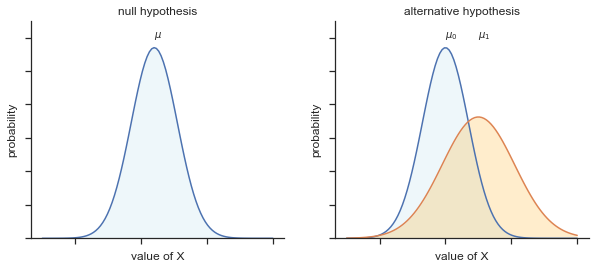

In [74]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

x = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 12,3.5)
y2=stats.norm.pdf(x,15,3.5)

ax[0].plot(x,y)
ax[0].set_ylabel("probability")
ax[0].set_xlabel("value of X")
ax[0].set_title("null hypothesis")
ax[0].set_ylim(0,0.13)
ax[0].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].annotate("$\mu$", xy=(12,0.12),xytext=(12,0.12))

x = np.linspace(-5,30,100)
y=stats.norm.pdf(x, 10,3.5)
y2=stats.norm.pdf(x,15,5.5)


ax[1].plot(x,y)
ax[1].plot(x,y2)
ax[1].set_ylabel("probability")
ax[1].set_xlabel("value of X")
ax[1].set_title("alternative hypothesis")
ax[1].set_ylim(0,0.13)
ax[1].fill_between(x,y, where=y>0.0,interpolate=True,facecolor='lightblue',alpha=0.2)
ax[1].fill_between(x,y2, where=y>0.0,interpolate=True,facecolor='orange',alpha=0.2)
ax[1].annotate("$\mu_0$", xy=(10,0.12),xytext=(10,0.12))
ax[1].annotate("$\mu_1$", xy=(15,0.12),xytext=(15,0.12))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

sns.despine(top=True, right=True)
glue("twosamplewelchtestdist_fig",fig,display=False)

```{glue:figure} twosamplewelchtestdist_fig
:figwidth: 650px
:name: "fig:twosamplewelchtestdist"

Graphical illustration of the null and alternative hypotheses assumed by the Welch  $t$-test. Like the Student test we assume that both samples are drawn from a normal population; but the alternative hypothesis no longer requires the two populations to have equal variance.
```

### Doing the test in Python

To run a Welch test in Python is pretty easy. All you have to do in pingouin it to tell the `ttest()` function to not assume equal variances but setting `correction=True`.  I like to do this explicitly.  If you do not provide the correction command to pinguoin it will run a test (see below) to see if the standard deviations seem like they might be different and then choses to use the correct or not.  By being explicit in your code is good practice.

In [21]:
pg.ttest(x=group1, y=group2, correction=True).round(3)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.034,23.02,two-sided,0.054,"[-11.05, 0.09]",0.74,1.556,0.536


Not too difficult, right? Not surprisingly, the output has exactly the same format as it did last time too.  Of course all the numbers are a bit different. But I hope that the interpretation of this output should be fairly obvious. You read the output in the same way that you would for the Student test. You've got your descriptive statistics, the hypotheses, the test results and some other information. So that's all pretty easy. 

Except, except... our result isn't significant anymore. When we ran the Student test, we did get a significant effect; but the Welch test on the same data set is not ($t(23.03) = 2.03$, $p = .054$). What does this mean? Should we panic? Is the sky burning? Probably not. The fact that one test is significant and the other isn't doesn't itself mean very much, especially since I kind of rigged the data so that this would happen. As a general rule, it's not a good idea to go out of your way to try to interpret or explain the difference between a $p$-value of .049 and a $p$-value of .051. If this sort of thing happens in real life, the *difference* in these $p$-values is almost certainly due to chance. What does matter is that you take a little bit of care in thinking about what test you use. The Student test and the Welch test have different strengths and weaknesses. If the two populations really do have equal variances, then the Student test is slightly more powerful (lower Type II error rate) than the Welch test. However, if they *don't* have the same variances, then the assumptions of the Student test are violated and you may not be able to trust it: you might end up with a higher Type I error rate. So it's a trade off. However, in real life, I tend to prefer the Welch test; because almost no-one *actually* believes that the population variances are identical.

### Assumptions of the test

The assumptions of the Welch test are very similar to those made by the Student $t$-test, except that the Welch test does not assume homogeneity of variance. This leaves only the assumption of normality, and the assumption of independence. The specifics of these assumptions are the same for the Welch test as for the Student test. 




## The paired-samples $t$-test

Regardless of whether we're talking about the Student test or the Welch test, an independent samples $t$-test is intended to be used in a situation where you have two samples that are, well, independent of one another. This situation arises naturally when participants are assigned randomly to one of two experimental conditions, but it provides a very poor approximation to other sorts of research designs. In particular, a repeated measures design -- in which each participant is measured (with respect to the same outcome variable) in both experimental conditions -- is not suited for analysis using independent samples $t$-tests. For example, we might be interested in whether listening to music reduces people's working memory capacity. To that end, we could measure each person's working memory capacity in two conditions: with music, and without music. In an experimental design such as this one, each participant appears in *both* groups. This requires us to approach the problem in a different way; by using the **_paired samples $t$-test_**.

### The data

The data set that we'll use this time comes from Dr Chico's class. In her class, students take two major tests, one early in the semester and one later in the semester. To hear her tell it, she runs a very hard class, one that most students find very challenging; but she argues that by setting hard assessments, students are encouraged to work harder. Her theory is that the first test is a bit of a "wake up call" for students: when they realise how hard her class really is, they'll work harder for the second test and get a better mark. Is she right? To test this, let's have a look at the `chico.csv` file: 

In [75]:
chico_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/chico.csv',index_col=0)
chico_df.head()

,id,grade_test1,grade_test2
1,student1,42.9,44.6
2,student2,51.8,54.0
3,student3,71.7,72.3
4,student4,51.6,53.4
5,student5,63.5,63.8


The pandas data frame `chico` contains three variables: an `id` variable that identifies each student in the class, the `grade_test1` variable that records the student grade for the first test, and the `grade_test2` variable that has the grades for the second test. Above are the first five students.

At a glance, it does seem like the class is a hard one (most grades are between 50\% and 60\%), but it does look like there's an improvement from the first test to the second one. If we take a quick look at the descriptive statistics

In [76]:
chico_df.describe()

,grade_test1,grade_test2
count,20.000000,20.000000
mean,56.980000,58.385000
std,6.616137,6.405612
min,42.900000,44.600000
25%,51.750000,53.100000
50%,57.700000,59.700000
75%,62.050000,63.050000
max,71.700000,72.300000


we see that this impression seems to be supported. Across all 20 students the mean grade for the first test is 57\%, but this rises to 58\% for the second test. Although, given that the standard deviations are 6.6\% and 6.4\% respectively, it's starting to feel like maybe the improvement is just illusory; maybe just random variation. This impression is reinforced when you see the means and confidence intervals plotted in {numref}`fig:chicogrades`. If we were to rely on this plot alone, we'd come to the same conclusion that we got from looking at the descriptive statistics that the `describe()` function produced. Looking at how wide those confidence intervals are, we'd be tempted to think that the apparent improvement in student performance is pure chance.

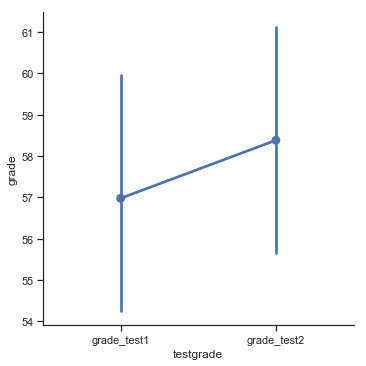

In [81]:
chico_tidy_df = chico_df.melt(id_vars='id', var_name="testgrade", value_name='grade')
fig=sns.catplot(x='testgrade',y='grade',kind='point',data=chico_tidy_df)
glue("chicogrades_fig",fig.fig,display=False)

```{glue:figure} chicogrades_fig
:figwidth: 650px
:name: "fig:chicogrades"

Mean grade for test 1 and test 2, with associated 95% confidence intervals.
```

Nevertheless, this impression is wrong. To see why, take a look at the scatterplot of the grades for test 1 against the grades for test 2 shown in {numref}`fig:chicogradesscatter`. 

In [78]:
chico_df.head()

,id,grade_test1,grade_test2
1,student1,42.9,44.6
2,student2,51.8,54.0
3,student3,71.7,72.3
4,student4,51.6,53.4
5,student5,63.5,63.8


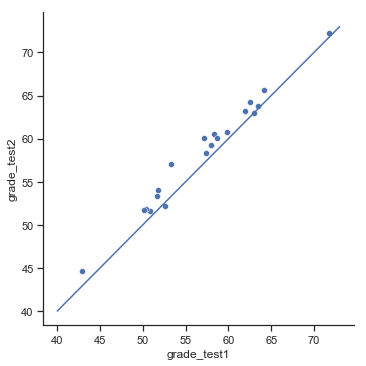

In [87]:
fig=sns.relplot(x=chico_df['grade_test1'],y=chico_df['grade_test2'])
x=np.linspace(40,73,100)
plt.plot(x,x)
glue("chicogradesscatter_fig",fig.fig,display=False)

```{glue:figure} chicogradesscatter_fig
:figwidth: 650px
:name: "fig:chicogradesscatter"

Scatterplot showing the individual grades for test 1 and test 2.
```

In this plot, each dot corresponds to the two grades for a given student: if their grade for test 1 ($x$ co-ordinate) equals their grade for test 2 ($y$ co-ordinate), then the dot falls on the line. Points falling above the line are the students that performed better on the second test. Critically, almost all of the data points fall above the diagonal line: almost all of the students *do* seem to have improved their grade, if only by a small amount. This suggests that we should be looking at the *improvement* made by each student from one test to the next, and treating that as our raw data. To do this, we'll need to create a new variable for the `improvement` that each student makes, and add it to the `chico` data frame. The easiest way to do this is as follows: 

In [90]:
chico_df['improvement']=chico_df['grade_test2']-chico_df['grade_test1']

Notice that I assigned the output to a variable called `chico$improvement`. That has the effect of creating a new variable called `improvement` inside the `chico` data frame. So now when I look at the `chico` data frame, I get an output that looks like this:

In [91]:
chico_df.head()

,id,grade_test1,grade_test2,improvement
1,student1,42.9,44.6,1.7
2,student2,51.8,54.0,2.2
3,student3,71.7,72.3,0.6
4,student4,51.6,53.4,1.8
5,student5,63.5,63.8,0.3


Now that we've created and stored this `improvement` variable, we can draw a histogram showing the distribution of these improvement scores (using the `hist()` function), shown in Figure {numref}`fig:chicoimprove`. 

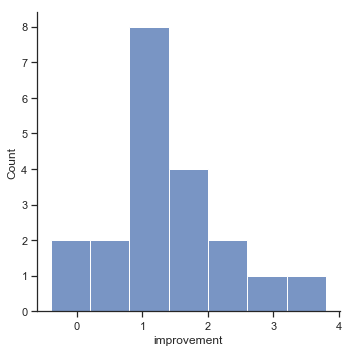

In [92]:
fig=sns.displot(chico_df.improvement,kde=False)
glue("chicoimprove_fig",fig.fig,display=False)

```{glue:figure} chicoimprove_fig
:figwidth: 650px
:name: "fig:chicoimprove"

Histogram of improvement variable.
```

When we look at histogram, it's very clear that there *is* a real improvement here. The vast majority of the students scored higher on the test 2 than on test 1, reflected in the fact that almost the entire histogram is above zero. In fact, if we use `aggregate()` with a custom function (`mean_confidence_interval()`) to compute a confidence interval for the population mean of this new variable, 

In [67]:
def mean_confidence_interval(data, confidence=0.95):
    a = data
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.DataFrame({"mean":[m], "lower 95CI": [m-h], "upper 95CI":[m+h]})

chico_df.improvement.aggregate(mean_confidence_interval).round(2)

,mean,lower 95CI,upper 95CI
0,1.4,0.95,1.86


we see that it is 95\% certain that the true (population-wide) average improvement would lie between 0.95\% and 1.86\%. So you can see, qualitatively, what's going on: there is a real "within student" improvement (everyone improves by about 1\%), but it is very small when set against the quite large "between student" differences (student grades vary by about 20\% or so). 

### What is the paired samples $t$-test?

In light of the previous exploration, let's think about how to construct an appropriate $t$ test. One possibility would be to try to run an independent samples $t$-test using `grade_test1` and `grade_test2` as the variables of interest. However, this is clearly the wrong thing to do: the independent samples $t$-test assumes that there is no particular relationship between the two samples. Yet clearly that's not true in this case, because of the repeated measures structure to the data. To use the language that I introduced in the last section, if we were to try to do an independent samples $t$-test, we would be conflating the **_within subject_** differences (which is what we're interested in testing) with the **_between subject_** variability (which we are not). 

The solution to the problem is obvious, I hope, since we already did all the hard work in the previous section. Instead of running an independent samples $t$-test on `grade_test1` and `grade_test2`, we run a *one-sample* $t$-test on the within-subject difference variable, `improvement`. To formalise this slightly, if $X_{i1}$ is the score that the $i$-th participant obtained on the first variable, and $X_{i2}$ is the score that the same person obtained on the second one, then the difference score is:
$
D_{i} = X_{i1} - X_{i2} 
$
Notice that the difference scores is *variable 1 minus variable 2* and not the other way around, so if we want improvement to correspond to a positive valued difference, we actually want "test 2" to be our "variable 1". Equally, we would say that $\mu_D = \mu_1 - \mu_2$ is the population mean for this difference variable. So, to convert this to a hypothesis test, our null hypothesis is that this mean difference is zero; the alternative hypothesis is that it is not:

$
\begin{array}{ll}
H_0: & \mu_D = 0  \\
H_1: & \mu_D \neq 0
\end{array}
$

(this is assuming we're talking about a two-sided test here). This is more or less identical to the way we described the hypotheses for the one-sample $t$-test: the only difference is that the specific value that the null hypothesis predicts is 0. And so our $t$-statistic is defined in more or less the same way too. If we let $\bar{D}$ denote the mean of the difference scores, then 

$
t = \frac{\bar{D}}{\mbox{SE}({\bar{D}})}
$

which is 

$
t = \frac{\bar{D}}{\hat\sigma_D / \sqrt{N}}
$

where $\hat\sigma_D$ is the standard deviation of the difference scores. Since this is just an ordinary, one-sample $t$-test, with nothing special about it, the degrees of freedom are still $N-1$. And that's it: the paired samples $t$-test really isn't a new test at all: it's a one-sample $t$-test, but applied to the difference between two variables. It's actually very simple; the only reason it merits a discussion as long as the one we've just gone through is that you need to be able to recognize *when* a paired samples test is appropriate, and to understand *why* it's better than an independent samples $t$ test.

### Doing the test in Python


How do you do a paired samples $t$-test in python. One possibility is to follow the process I outlined above: create a "difference" variable and then run a one sample $t$-test on that. Since we've already created a variable called `chico_df['improvement']`, let's do that:

In [93]:
pg.ttest(x=chico_df['improvement'], y=0).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.48,19,two-sided,0.0,"[0.95, 1.86]",1.45,5991.577,1.0


The output here is (obviously) formatted exactly the same was as it was the last time we used the `ttest()` function, and it confirms our intuition. There's an average improvement of 1.4\% from test 1 to test 2, and this is significantly different from 0 ($t(19)=6.48, p<.001$). 

However, suppose you're lazy and you don't want to go to all the effort of creating a new variable. Or perhaps you just want to keep the difference between one-sample and paired-samples tests clear in your head. If so, you can still use the `ttest()` function. Let's assume that your data organised like they are in the `chico` data frame, where there are two separate variables, one for each measurement. You can still provide each column as group 1 and group 2 as before but just indicate they are paried with the argument `paired=True`:

In [72]:
group1 = chico_df.grade_test1
group2 = chico_df.grade_test2
pg.ttest(x=group1, y=group2, paired=True).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-6.48,19,two-sided,0.0,"[-1.86, -0.95]",0.22,5991.577,0.15


The numbers are identical to those that come from the one sample test on the improvment column, which of course they have to be given that the paired samples $t$-test is just a one sample test under the hood.

## One sided tests

When introducing the theory of null hypothesis tests, I mentioned that there are some situations when it's appropriate to specify a *one-sided* test (see above). So far, all of the $t$-tests have been two-sided tests. For instance, when we specified a one sample $t$-test for the grades in Dr Zeppo's class, the null hypothesis was that the true mean was 67.5\%. The alternative hypothesis was that the true mean was greater than *or* less than 67.5\%. Suppose we were only interested in finding out if the true mean is greater than 67.5\%, and have no interest whatsoever in testing to find out if the true mean is lower than 67.5\%. If so, our null hypothesis would be that the true mean is 67.5\% or less, and the alternative hypothesis would be that the true mean is greater than 67.5\%. The pingouin `ttest()` function lets you do this, by specifying the `tail` argument. If you set `tail="greater"`, it means that you're testing to see if the true mean is larger than `mu`. If you set `tail="less"`, then you're testing to see if the true mean is smaller than `mu`. Here's how it would work for Dr Zeppo's class:

In [109]:
# old version
pg.ttest(x=zeppo_df.grades,y=67.5)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.255,19,two-sided,0.036145,"[0.34, 9.26]",0.504,1.795,0.571


In [110]:
pg.ttest(x=zeppo_df.grades,y=67.5,tail='greater')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.255,19,greater,0.018073,"[1.12, inf]",0.504,3.59,0.701


Notice that there are a few changes from the output that we saw last time. Most important is the fact that the tail output has changed predictably. The second thing to note is that, although the $t$-statistic and degrees of freedom have not changed, the $p$-value has. This is because the one-sided test has a different rejection region from the two-sided test. If you've forgotten why this is and what it means, you may find it helpful to read back over Chapter on hypothesis testing, and Section on one-sided tests in particular. The third thing to note is that the confidence interval is different too: it now reports a "one-sided" confidence interval rather than a two-sided one. In a two-sided confidence interval, we're trying to find numbers $a$ and $b$ such that we're 95\% confident that the true mean lies *between* $a$ and $b$. In a one-sided confidence interval, we're trying to find a single number $a$ such that we're 95\% confident that the true mean is *greater than* $a$ (or less than $a$ if you set `tail="less"`).

So that's how to do a one-sided one sample $t$-test. However, all versions of the $t$-test can be one-sided. For an independent samples $t$ test, you could have a one-sided test if you're only interestd in testing to see if group A has *higher* scores than group B, but have no interest in finding out if group B has higher scores than group A. Let's suppose that, for Dr Harpo's class, you wanted to see if Anastasia's students had higher grades than Bernadette's. The `ttest()` function lets you do this, again by specifying the `tail` argument.

In [78]:
group1 = harpo_df[harpo_df['tutor']=="Bernadette"].grade
group2 = harpo_df[harpo_df['tutor']=="Anastasia"].grade

pg.ttest(x=group1, y=group2, correction=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.12,31,less,0.02,"[-inf, -1.09]",0.74,3.51,0.66


Again, the output changes in a predictable way. The definition of the null and alternative hypotheses has changed, the $p$-value has changed, and it now reports a one-sided confidence interval rather than a two-sided one.  You might be surprised that although we specified `tail="one-sided"` in the code, the output says `tail=less`.  This is because pinguoin's `ttest()` function automatically infers which side the one tail should appear on.  Since the t-value is negative here it chose `less` but if you swap the groups arguments it will flip to `greater`:

In [80]:
group1 = harpo_df[harpo_df['tutor']=="Bernadette"].grade
group2 = harpo_df[harpo_df['tutor']=="Anastasia"].grade

pg.ttest(x=group2, y=group1, correction=False, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.12,31,greater,0.02,"[1.09, inf]",0.74,3.51,0.66


For this reason as long as you specify the `tail` correct you don't need to worry about it!

What about the paired samples $t$-test? Suppose we wanted to test the hypothesis that grades go *up* from test 1 to test 2 in Dr Zeppo's class, and are not prepared to consider the idea that the grades go down. Again, we can use the `tail` argument to specify the one-sided test, and it works the same way it does for the independent samples $t$-test.  If your data are in wide form, as they are in the `chico` data frame, you'd use this command:

In [79]:
group1 = chico_df.grade_test1
group2 = chico_df.grade_test2
pg.ttest(x=group1, y=group2, paired=True, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-6.48,19,less,0.0,"[-inf, -1.03]",0.22,1.198e+04,0.24


Yet again, the output changes in a predictable way. The hypotheses have changed, the $p$-value has changed, and the confidence interval is now one-sided. 

## Effect size

The most commonly used measure of effect size for a $t$-test is **_Cohen's $d$_** {cite}`Cohen1988`. It's a very simple measure in principle, with quite a few wrinkles when you start digging into the details. Cohen himself defined it primarily in the context of an independent samples $t$-test, specifically the Student test. [^dprime] In that context, a natural way of defining the effect size is to divide the difference between the means by an estimate of the standard deviation. In other words, we're looking to calculate *something* along the lines of this:
$
d = \frac{\mbox{(mean 1)} - \mbox{(mean 2)}}{\mbox{std dev}}
$
and he suggested a rough guide for interpreting $d$ in {numref}`tab:effect_size`. You'd think that this would be pretty unambiguous, but it's not; largely because Cohen wasn't too specific on what he thought should be used as the measure of the standard deviation (in his defence, he was trying to make a broader point in his book, not nitpick about tiny details). As discussed by {cite}`McGrath2006`, there are several different version in common usage, and each author tends to adopt slightly different notation. For the sake of simplicity (as opposed to accuracy) I'll use $d$ to refer to any statistic that you calculate from the sample, and  use $\delta$ to refer to a theoretical population effect. Obviously, that does mean that there are several different things all called $d$. pingouin has a number of different functions for computing [effect sizes](https://pingouin-stats.org/api.html#effect-sizes).  

My suspicion is that the only time that you would want Cohen's $d$ is when you're running a $t$-test, and the good news is that the pingouin `ttest()` function we saw already output the cohen's d for the given test!

[^dprime]: It is no accident that cohen's d measure looks and sounds a lot like d' which we will cover in the next chapter!  They measure roughly the same thing!

In [4]:
effect_size_df=pd.DataFrame({"d-value": ['about 0.2', 'about 0.5', 'about 0.8'], "rough interpretation": ['small effect', 'moderate effect', 'large effect']}).set_index("d-value")
glue("effect_size_tab", effect_size_df, display=False)

```{glue:figure} effect_size_tab
:figwidth: 550px
:name: "tab:effect_size"

A (very) rough guide to interpreting Cohen's $d$. My personal recommendation is to not use these blindly. The $d$ statistic has a natural interpretation in and of itself: it redescribes the different in means as the number of standard deviations that separates those means. So it's generally a good idea to think about what that means in practical terms. In some contexts a \"small\" effect could be of big practical importance. In other situations a \"large\" effect may not be all that interesting.
```

### Cohen's $d$ from one sample

The simplest situation to consider is the one corresponding to a one-sample $t$-test. In this case, the one sample mean $\bar{X}$ and one (hypothesised) population mean $\mu_o$ to compare it to. Not only that, there's really only one sensible way to estimate the population standard deviation: we just use our usual estimate $\hat{\sigma}$. Therefore, we end up with the following as the only way to calculate $d$, 
$
d = \frac{\bar{X} - \mu_0}{\hat{\sigma}}
$

First lets check the output of the t-test again for Dr. Zeppo's class (the one sample t-test):

In [93]:
pg.ttest(x=zeppo_df.grades,y=67.5)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.255,19,two-sided,0.036145,"[0.34, 9.26]",0.504,1.795,0.571


And here is how to use the pingouin effect size function:

In [92]:
pg.compute_effsize(x=zeppo_df.grades,y=67.5, eftype='cohen')

0.5041691240370938

Yep, same number. Overall, then, the psychology students in Dr Zeppo's class are achieving grades (mean = 72.3\%) that are about .5 standard deviations higher than the level that you'd expect (67.5\%) if they were performing at the same level as other students. Judged against Cohen's rough guide, this is a moderate effect size.

### Cohen's $d$ from a Student $t$ test

The majority of discussions of Cohen's $d$ focus on a situation that is analogous to Student's independent samples $t$ test, and it's in this context that the story becomes messier, since there are several different versions of $d$ that you might want to use in this situation, and you can use the `eftype` argument to the `compute_effsize()` function to pick the one you want (see the options [here](https://pingouin-stats.org/generated/pingouin.compute_effsize.html#pingouin.compute_effsize)). To understand why there are multiple versions of $d$, it helps to take the time to write down a formula that corresponds to the true population effect size $\delta$. It's pretty straightforward, 
$
\delta = \frac{\mu_1 - \mu_2}{\sigma}
$
where, as usual, $\mu_1$ and $\mu_2$ are the population means corresponding to group 1 and group 2 respectively, and $\sigma$ is the standard deviation (the same for both populations). The obvious way to estimate $\delta$ is to do exactly the same thing that we did in the $t$-test itself: use the sample means as the top line, and a pooled standard deviation estimate for the bottom line:
$
d = \frac{\bar{X}_1 - \bar{X}_2}{\hat{\sigma}_p}
$
where $\hat\sigma_p$ is the exact same pooled standard deviation measure that appears in the $t$-test. This is the most commonly used version of Cohen's $d$ when applied to the outcome of a Student $t$-test ,and is sometimes referred to as Hedges' $g$ statistic {cite}`Hedges1981`. It corresponds to `eftype = "hedges"` in the `compute_effsize()` function, and it's the default. 

However, there are other possibilities, which I'll briefly describe. Firstly, you may have reason to want to use only one of the two groups as the basis for calculating the standard deviation. This approach (often called Glass' $\Delta$) only makes most sense when you have good reason to treat one of the two groups as a purer reflection of "natural variation" than the other. This can happen if, for instance, one of the two groups is a control group. If that's what you want, then use `method = "glass"` when using `compute_effsize()`. Note that the pingouin version of this function uses the group with the lowest variance for this calculation rather than letting you choose.  

In any case, ignoring all those variations that you could make use of if you wanted, let's have a look at how to calculate the default version.

In [94]:
group1 = harpo_df[harpo_df['tutor']=="Bernadette"].grade
group2 = harpo_df[harpo_df['tutor']=="Anastasia"].grade

pg.ttest(x=group1, y=group2, correction=False).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.12,31,two-sided,0.04,"[-10.76, -0.2]",0.74,1.755,0.54


In [107]:
group1 = harpo_df[harpo_df['tutor']=="Bernadette"].grade
group2 = harpo_df[harpo_df['tutor']=="Anastasia"].grade

print("Different versions")
print("----")
print("Cohens:",pg.compute_effsize(x=group1,y=group2, eftype='cohen'))
print("Hedges:",pg.compute_effsize(x=group1,y=group2, eftype='hedges'))
print("Glass (using minimum variance group):",pg.compute_effsize(x=group1,y=group2, eftype='glass'))

Different versions
----
Cohens: -0.7395614040382655
Hedges: -0.7215233210129419
Glass (using minimum variance group): -0.9485464839690173


### Cohen's $d$ from a Welch test

Suppose the situation you're in is more like the Welch test: you still have two independent samples, but you no longer believe that the corresponding populations have equal variances. When this happens, we have to redefine what we mean by the population effect size. I'll refer to this new measure as $\delta^\prime$, so as to keep it distinct from the measure $\delta$ which we defined previously. What {cite}`Cohen1988` suggests is that we could define our new population effect size by averaging the two population variances. What this means is that we get:
$
\delta^\prime = \frac{\mu_1 - \mu_2}{\sigma^\prime}
$
where 
$
\sigma^\prime = \sqrt{\displaystyle{\frac{ {\sigma_1}^2 + {\sigma_2}^2}{2}}}
$
This seems quite reasonable, but notice that none of the measures that we've discussed so far are attempting to estimate this new quantity. It might just be my own ignorance of the topic, but I'm only aware of one version of Cohen's $d$ that actually estimates the unequal-variance effect size $\delta^\prime$ rather than the equal-variance effect size $\delta$.
All we do to calculate $d$ for this version (`method = "unequal"`) is substitute the sample means $\bar{X}_1$ and $\bar{X}_2$ and the corrected sample standard deviations $\hat{\sigma}_1$ and $\hat{\sigma}_2$ into the equation for $\delta^\prime$. This gives us the following equation for $d$, 
$
d = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\displaystyle{\frac{ {\hat\sigma_1}^2 + {\hat\sigma_2}^2}{2}}}}
$
as our estimate of the effect size. This version is not computed by the current version of pingouin so you'll have to implement it by hand if you want to use it.

In [108]:
pg.ttest(x=group1,y=group2, correction=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.034,23.02,two-sided,0.05361,"[-11.05, 0.09]",0.74,1.556,0.536


### Cohen's $d$ from a paired-samples test


Finally, what should we do for a paired samples $t$-test? In this case, the answer depends on what it is you're trying to do. *If* you want to measure your effect sizes relative to the distribution of difference scores, the measure of $d$ that you calculate is just (`method = "paired"`)
$
d = \frac{\bar{D}}{\hat{\sigma}_D}
$
where $\hat{\sigma}_D$ is the estimate of the standard deviation of the differences. The calculation here is pretty straightforward.  What we see is that the overall effect of the differences size is quite large ($d$>1.0).

In [120]:
chico_df.improvement.mean()/chico_df.improvement.std()

1.4479515277482184

In [117]:
pg.ttest(x=chico_df.improvement, y=0).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.48,19,two-sided,0.0,"[0.95, 1.86]",1.45,5991.577,1.0


In [116]:
print("Different versions")
print("----")
print("Cohens:",pg.compute_effsize(x=chico_df.improvement,y=0, eftype='cohen'))
print("Hedges:",pg.compute_effsize(x=chico_df.improvement,y=0, eftype='hedges'))
print("Glass (using minimum variance group):",pg.compute_effsize(x=chico_df.improvement,y=0, eftype='glass'))

Different versions
----
Cohens: 1.4479515277482184
Hedges: 1.4479515277482184
Glass (using minimum variance group): 1.4479515277482184


The only wrinkle is figuring out whether this is the measure you want or not. To the extent that you care about the practical consequences of your research, you often want to measure the effect size relative to the *original* variables, not the *difference* scores (e.g., the 1\% improvement in Dr Chico's class is pretty small when measured against the amount of between-student variation in grades), in which case you use the same versions of Cohen's $d$ that you would use for a Student or Welch test. For instance, when we do that for Dr Chico's class, 



In [128]:
pg.compute_effsize(x=chico_df.grade_test2,  y=chico_df.grade_test1, paired=True)

0.21579282752456122

What we see is that the overall effect size is quite small, when assessed on the scale of the original variables.

## Checking the normality of a sample

All of the tests that we have discussed so far in this chapter have assumed that the data are normally distributed. This assumption is often quite reasonable, because the central limit theorem does tend to ensure that many real world quantities are normally distributed: any time that you suspect that your variable is *actually* an average of lots of different things, there's a pretty good chance that it will be normally distributed; or at least close enough to normal that you can get away with using $t$-tests. However, life doesn't come with guarantees; and besides, there are lots of ways in which you can end up with variables that are highly non-normal. For example, any time you think that your variable is actually the minimum of lots of different things, there's a very good chance it will end up quite skewed. In psychology, response time (RT) data is a good example of this. If you suppose that there are lots of things that could trigger a response from a human participant, then the actual response will occur the first time one of these trigger events occurs. (This is a massive oversimplification.) This means that RT data are systematically non-normal.  Okay, so if normality is assumed by all the tests, and is mostly but not always satisfied (at least approximately) by real world data, how can we check the normality of a sample? In this section I discuss two methods: QQ plots, and the Shapiro-Wilk test.

### QQ plots

One way to check whether a sample violates the normality assumption is to draw a **_"quantile-quantile" plot_** (QQ plot). This allows you to visually check whether you're seeing any systematic violations. In a QQ plot, each observation is plotted as a single dot. The x co-ordinate is the theoretical quantile that the observation should fall in, if the data were normally distributed (with mean and variance estimated from the sample) and on the y co-ordinate is the actual quantile of the data within the sample. If the data are normal, the dots should form a straight line. For instance, lets see what happens if we generate data by sampling from a normal distribution, and then drawing a QQ plot using the python function `qqplot()` from the statsmodels package ([documentation here](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html)). The `qqplot()` function has a few arguments, but the only one we really need to care about here is `data`, a vector specifying the data whose normality we're interested in checking. Here's the Python commands:

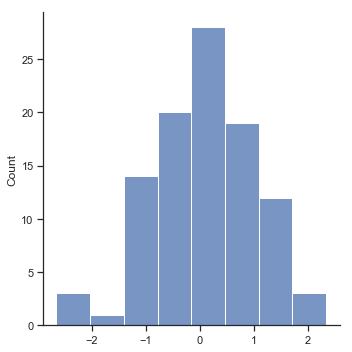

In [5]:
normal_data = np.random.normal(0,1,100)
fig=sns.displot(normal_data,kde=False)
glue("normaldata_fig",fig.fig,display=False)

```{glue:figure} normaldata_fig
:figwidth: 550px
:name: "fig:normal_data"

Histogram of `normal_data`, a normally distributed sample with 100 observations.
```

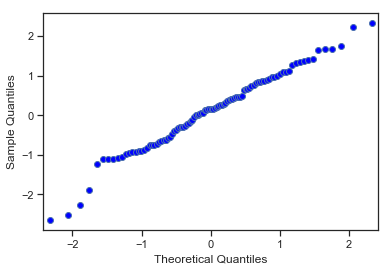

In [9]:
import statsmodels.api as sm
sm.qqplot(normal_data)
glue("qqplot_fig",fig.fig,display=False)

```{glue:figure} qqplot_fig
:figwidth: 550px
:name: "fig:qqplot"

Normal QQ plot of `normal_data`, a normally distributed sample with 100 observations.
```

As we can see the QQ plot of random normal data is approximately linear and so we can be lead to believe that this is mostly normal data.

### Shapiro-Wilk tests

Although QQ plots provide a nice way to informally check the normality of your data, sometimes you'll want to do something a bit more formal. And when that moment comes, the **_Shapiro-Wilk test_** {cite}`Shapiro1965` is probably what you're looking for. (Either that, or the Kolmogorov-Smirnov test, which is probably more traditional than the Shapiro-Wilk, though most things I've read seem to suggest Shapiro-Wilk is the better test of normality; although Kolomogorov-Smirnov is a general purpose test of distributional equivalence, so it can be adapted to handle other kinds of distribution tests). As you'd expect, the null hypothesis being tested is that a set of $N$ observations is normally distributed. The test statistic that it calculates is conventionally denoted as $W$, and it's calculated as follows. First, we sort the observations in order of increasing size, and let $X_1$ be the smallest value in the sample, $X_2$ be the second smallest and so on. Then the value of $W$ is given by
$
W = \frac{ \left( \sum_{i = 1}^N a_i X_i \right)^2 }{ \sum_{i = 1}^N (X_i - \bar{X})^2}
$
where $\bar{X}$ is the mean of the observations, and the $a_i$ values are ... mumble, mumble ... something complicated that is a bit beyond the scope of an introductory text. 

Because it's a little hard to explain the maths behind the $W$ statistic, a better idea is to give a broad brush description of how it behaves. Unlike most of the test statistics that we'll encounter in this book, it's actually *small* values of $W$ that indicated departure from normality. The $W$ statistic has a maximum value of 1, which arises when the data look "perfectly normal". The smaller the value of $W$, the less normal the data are. However, the sampling distribution for $W$  -- which is not one of the standard ones that I discussed in Chapter on probability and is in fact a complete pain in the arse to work with -- does depend on the sample size $N$. To give you a feel for what these sampling distributions look like, I've plotted three of them in {numref}`shapiro-wilk`. Notice that, as the sample size starts to get large, the sampling distribution becomes very tightly clumped up near $W=1$, and as a consequence, for larger samples $W$ doesn't have to be very much smaller than 1 in order for the test to be significant. 


```{figure} ../../images/navarro_img/ttest2/shapirowilkdist-eps-converted-to.pdf
---
width: 600px
name: shapiro-wilk
---
Sampling distribution of the Shapiro-Wilk $W$ statistic, under the null hypothesis that the data are normally distributed, for samples of size 10, 20 and 50. Note that *small* values of $W$ indicate departure from normality.
```

To run the test in Python, we use the [scipy shapiro()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) function ( `stats.shapiro()`). It has only a single argument `x`, which is a numeric vector containing the data whose normality needs to be tested. For example, when we apply this function to  our `normal.data`, we get the following:

In [157]:
W, p=stats.shapiro(x=normal_data)

print(f"The value of W is {W}, p={p}")

The value of W is 0.9836190342903137, p=0.25148776173591614


So, not surprisingly, we have no evidence that these data depart from normality, the p value is high and the value of W is close to 1.0.  When reporting the results for a Shapiro-Wilk test, you should (as usual) make sure to include the test statistic $W$ and the $p$ value (the return values of the scipy function), though given that the sampling distribution depends so heavily on $N$ it would probably be a politeness to include $N$ as well.

### Examples

Let's step through a couple examples of this test for a few different simulated data sets.

The value of W is 0.9843708872795105, p=0.285838782787323


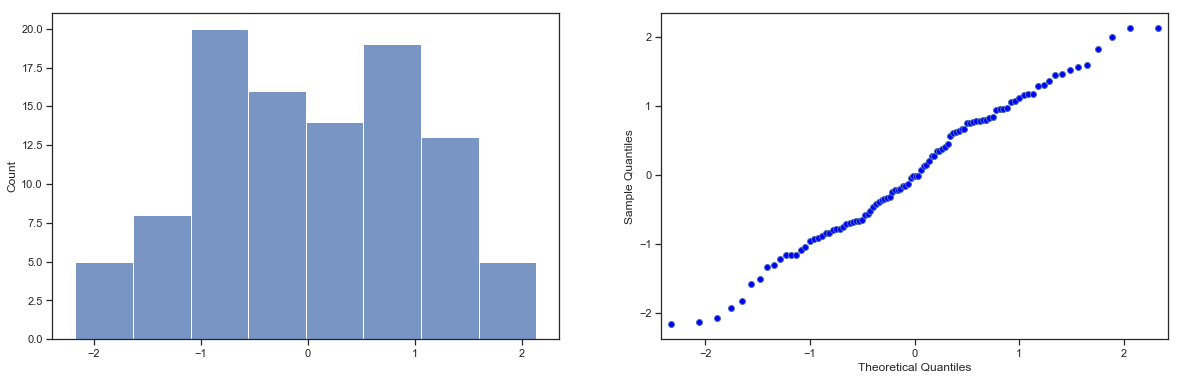

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax = ax.ravel()

normal_data = np.random.normal(0,1,100)
sns.histplot(normal_data,kde=False,ax=ax[0])

sm.qqplot(normal_data, ax=ax[1])

W, p=stats.shapiro(x=normal_data)

print(f"The value of W is {W}, p={p}")

glue("exp1_fig",fig,display=False)

```{glue:figure} exp1_fig
:figwidth: 650px
:name: "fig:exp1"

Normal QQ plot of `normal_data`, a normally distributed sample with 100 observations.  A normal QQ plot of the same data.
```

As you can see from the code block above, the Shapiro-Wilk statistic associated with the data in Figure 18 is $W ~= 1.0$, indicating that no significant departures from normality were detected. The p-value is also quite high. As you can see, these data form a pretty straight line; which is no surprise given that we sampled them from a normal distribution! 

In contrast, have a look at the two data sets shown in Figure 19 and 20. Figure 19 shows the histogram and a QQ plot for a data set that is highly skewed: the QQ plot curves downward. As a consequence, the Shapiro-Wilk statistic is $W~=.80$, reflecting a significant departure from normality ($p<.001$). Figure 20 show the same plots for a heavy tailed (i.e., high kurtosis) data set: in this case, the QQ plot flattens in the middle and curves sharply at either end.  The resulting Shapiro-Wilk statistic is $W ~ .80$, again reflecting significant non-normality ($p < .001$).

The value of W is 0.8032301664352417, p=3.115032953804331e-10


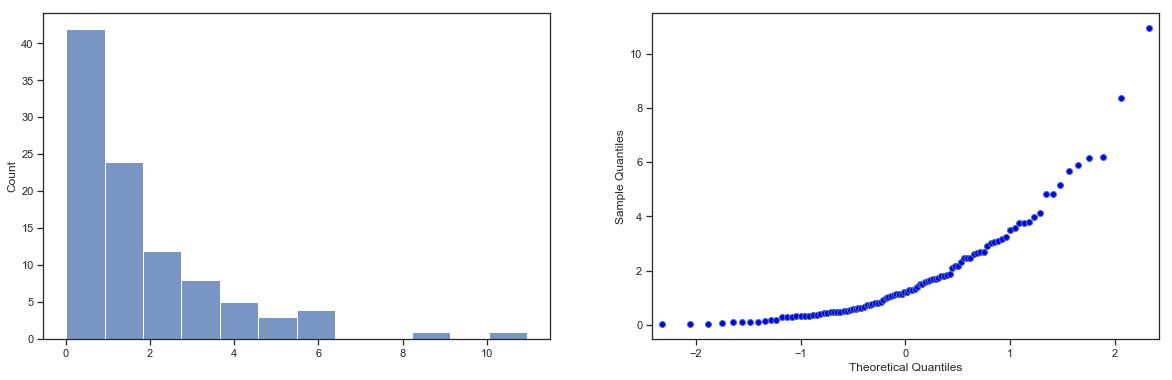

In [14]:
fi6, ax = plt.subplots(1,2, figsize=(20,6))
ax = ax.ravel()

skewed_data = np.random.gamma(1,2,100)
sns.histplot(skewed_data,kde=False,ax=ax[0])

sm.qqplot(skewed_data, ax=ax[1])

W, p=stats.shapiro(x=skewed_data)

print(f"The value of W is {W}, p={p}")
glue("exp2_fig",fig,display=False)

```{glue:figure} exp2_fig
:figwidth: 650px
:name: "fig:exp2"

Histogram of `skewed_data`, a Gamma(1,2) distributed sample with 100 observations.  A normal QQ plot of the same data.
```

The value of W is 0.8543360233306885, p=1.7206295055416376e-08


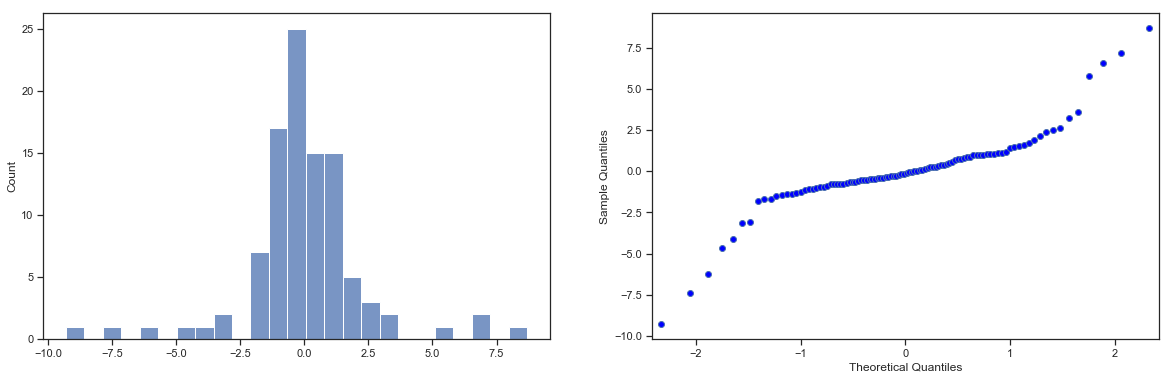

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax = ax.ravel()

heavy_tailed_data = np.concatenate((np.random.normal(0,1,80), np.random.normal(1,5,20)))
sns.histplot(heavy_tailed_data,kde=False,ax=ax[0])

sm.qqplot(heavy_tailed_data, ax=ax[1])

W, p=stats.shapiro(x=heavy_tailed_data)

print(f"The value of W is {W}, p={p}")
glue("exp3_fig",fig,display=False)

```{glue:figure} exp3_fig
:figwidth: 650px
:name: "fig:exp3"

Histogram of `heavy_tailed_data`, a normal (0,1) distributed sample with 80 observations mixed with 20 samples from N(1,5).  A normal QQ plot of the same data.
```



## Testing non-normal data with Wilcoxon tests

Okay, suppose your data turn out to be pretty substantially non-normal, but you still want to run something like a $t$-test? This situation occurs a lot in real life.  And this is the situation where you want to use Wilcoxon tests. 

Like the $t$-test, the Wilcoxon test comes in two forms, one-sample and two-sample, and they're used in more or less the exact same situations as the corresponding $t$-tests. Unlike the $t$-test, the Wilcoxon test doesn't assume normality, which is nice. In fact, they don't make any assumptions about what kind of distribution is involved: in statistical jargon, this makes them **_nonparametric tests_**. While avoiding the normality assumption is nice, there's a drawback: the Wilcoxon test is usually less powerful than the $t$-test (i.e., higher Type II error rate). I won't discuss the Wilcoxon tests in as much detail as the $t$-tests, but I'll give you a brief overview.

### Two sample Wilcoxon test

I'll start by describing the **_two sample Wilcoxon test_** (also known as the Mann-Whitney test), since it's actually simpler than the one sample version. Suppose we're looking at the scores of 10 people on some test. Since my imagination has now failed me completely, let's pretend it's a "test of awesomeness", and there are two groups of people, "A" and "B". I'm curious to know which group is more awesome. The data are included in the file `awesome.csv`, and like many of the data sets I've been using, it contains only a single data frame, in this case called `awesome`. Here's the data:

In [16]:
awesome_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/awesome.csv',index_col=0)
awesome_df

,scores,group
1,6.4,A
2,10.7,A
3,11.9,A
4,7.3,A
5,10.0,A
6,14.5,B
7,10.4,B
8,12.9,B
9,11.7,B
10,13.0,B


As long as there are no ties (i.e., people with the exact same awesomeness score), then the test that we want to do is surprisingly simple. All we have to do is construct a table that compares every observation in group $A$ against every observation in group $B$. Whenever the group $A$ datum is larger, we place a check mark in the table.

We then count up the number of checkmarks. This is our test statistic, $W$. (Actually, there are two different versions of the test statistic; they differ from each other by a constant value. The version that I've described is the one that Python calculates.) The actual sampling distribution for $W$ is somewhat complicated, and I'll skip the details. For our purposes, it's sufficient to note that the interpretation of $W$ is qualitatively the same as the interpretation of $t$ or $z$. That is, if we want a two-sided test, then we reject the null hypothesis when $W$ is very large or very small; but if we have a directional (i.e., one-sided) hypothesis, then we only use one or the other. 

The test to do this in pingouin is named for the Mann-Whitney version of the test (`mwu()`).  This it the non-parametric version of the independent t-test:

In [18]:
group1=awesome_df.groupby('group').get_group('A').scores
group2=awesome_df.groupby('group').get_group('B').scores
pg.mwu(x=group1, y=group2, tail='two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,3.0,two-sided,0.060103,0.76,0.88


The structure of the `mwu()` function should feel very familiar to you by now and is exactly like the pingouin `ttest()`.  Just like we saw with the `ttest()` function, there is an `tail` argument that you can use to switch between two-sided tests and one-sided tests.

The paired version of the test is called the Wilcoxon test and is provided by the `wilcoxon()` function in pinouin.  It is otherwise called the same way.

In [206]:
group1=awesome_df.groupby('group').get_group('A').scores
group2=awesome_df.groupby('group').get_group('B').scores
pg.wilcoxon(x=group1, y=group2, tail='two-sided')

/Users/gureckis/.virtualenvs/science/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,W-val,tail,p-val,RBC,CLES
Wilcoxon,1.0,two-sided,0.105645,-0.867,0.88


Notice that the paired and unpaired versions of the test are slightly different in terms of what p-values you get.

## Summary

- A one sample $t$-test is used to compare a single sample mean against a hypothesised value for the population mean. 
- An independent samples $t$-test is used to compare the means of two groups, and tests the null hypothesis that they have the same mean. It comes in two forms: the Student test  assumes that the groups have the same standard deviation, the Welch test  does not.
- A paired samples $t$-test is used when you have two scores from each person, and you want to test the null hypothesis that the two scores have the same mean. It is equivalent to taking the difference between the two scores for each person, and then running a one sample $t$-test on the difference scores.
- Effect size calculations for the difference between means can be calculated via the Cohen's $d$ statistic. 
- You can check the normality of a sample using QQ plots and the Shapiro-Wilk test. 
- If your data are non-normal, you can use Wilcoxon tests instead of $t$-tests. 

## References

```{bibliography} ../../references.bib
:filter: docname in docnames
```